# CVEs Forecast by Malware Type

The main purpose of this analysis is to forecast CVEs by Malware Type (virus, trojan, phishing...)

## Setup notebook

In [2]:
import os

# Load env variables
env_properties = {}

files = [
    f"../env/env.properties",
    f"../env/env.secrets"
]

for file in files:
    with open(file, "r") as f:
        for line in f:
            line = line.rstrip()

            if "=" not in line:
                continue
            if line.startswith("#"):
                continue

            k, v = line.split("=", 1)
            env_properties[k] = v

    for key, value in env_properties.items():
        os.environ[str(key)] = str(value)

os.environ["LOG_LEVEL"] = "ERROR"

os.chdir("../app")

## Classifying CVEs by Malware Type

### First iteration: Malware Type by Description
As a first iteration, Malware Type is obtained from CVE description, only looking for concrete words related to a concrete Malware Type.

This is the result:

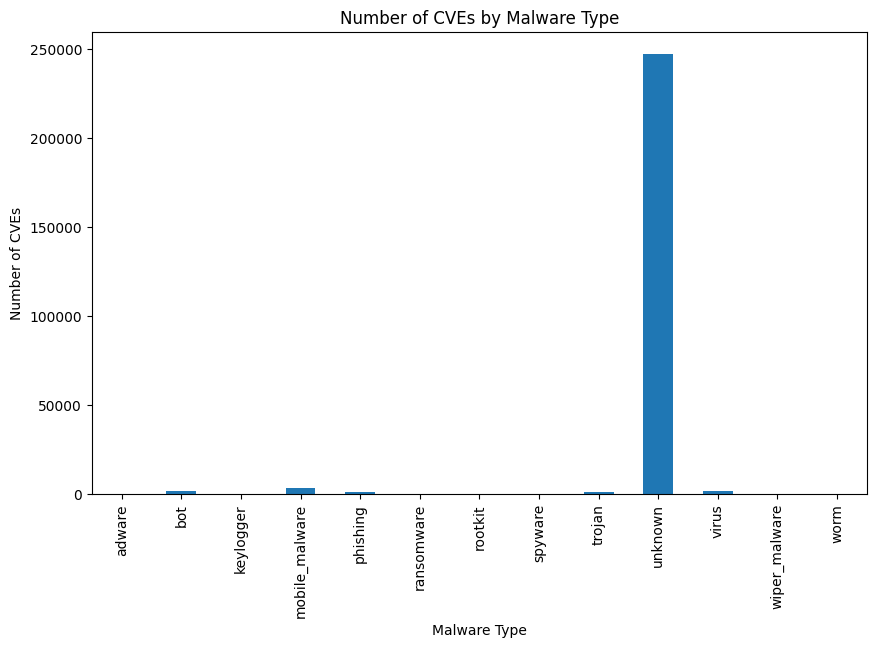

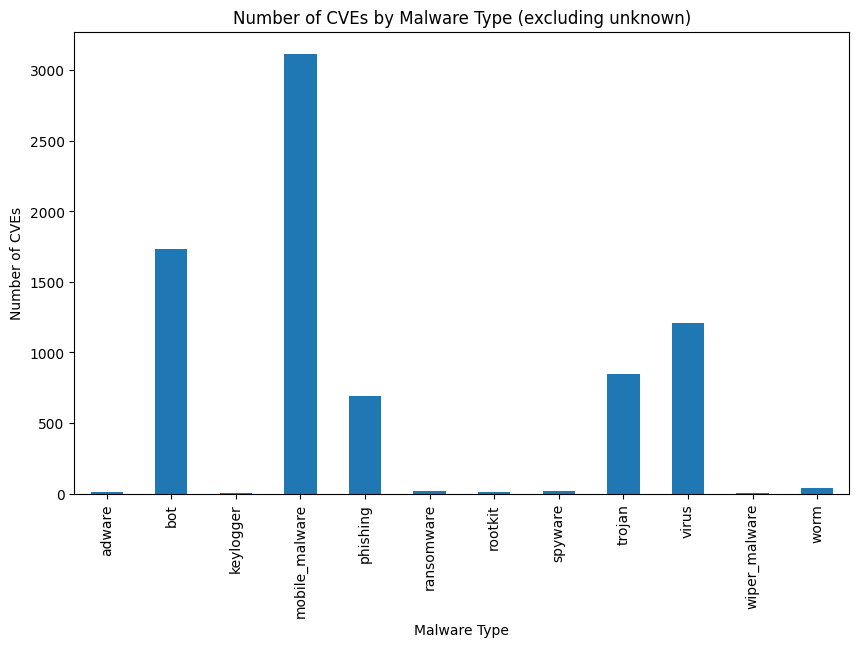

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

from src.infrastructure.mongodb_cve_repository import MongoDBCVERepository

# TODO change me
CVES_IT1_COLLECTION = (
        "cves_it1" + "_20240804"
    )

cves_it1_repository = MongoDBCVERepository(collection_name=CVES_IT1_COLLECTION)

cves = cves_it1_repository.find_all()

df = pd.DataFrame(list(cves))

malware_counts = df.groupby('malware_type').size()

# Crear una gráfica de barras
plt.figure(figsize=(10, 6))
malware_counts.plot(kind='bar')

# Agregar etiquetas y título
plt.xlabel('Malware Type')
plt.ylabel('Number of CVEs')
plt.title('Number of CVEs by Malware Type')

# Mostrar la gráfica
plt.show()

df_filtered = df[df['malware_type'] != 'unknown']

malware_counts_filtered = df_filtered.groupby('malware_type').size()

# Crear una gráfica de barras
plt.figure(figsize=(10, 6))
malware_counts_filtered.plot(kind='bar')

# Agregar etiquetas y título
plt.xlabel('Malware Type')
plt.ylabel('Number of CVEs')
plt.title('Number of CVEs by Malware Type (excluding unknown)')

# Mostrar la gráfica
plt.show()

### Second iteration: Malware Type predicted with NLP

As a second iteration, CVEs with unknown Malware Type are predicted with a NLP model.

This is the result:

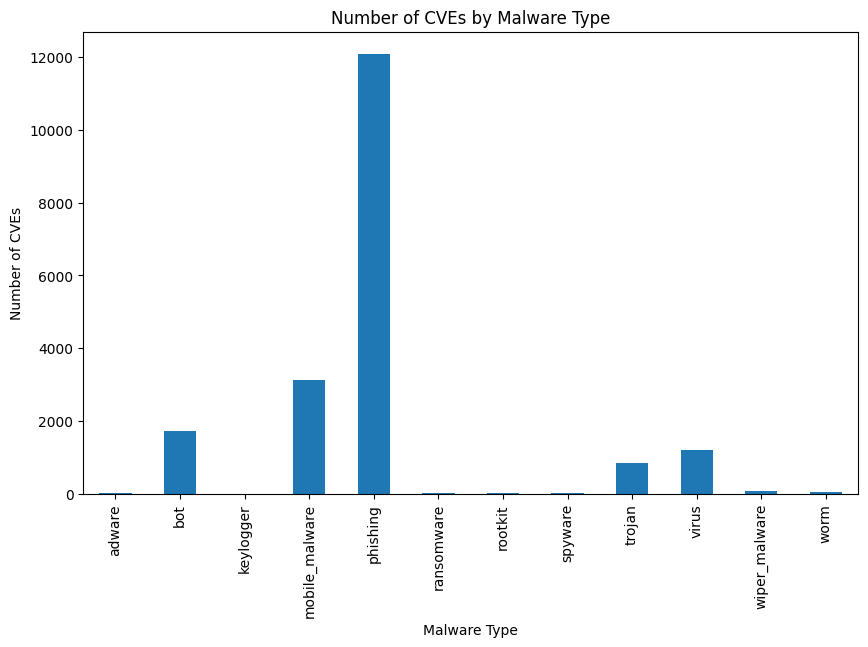

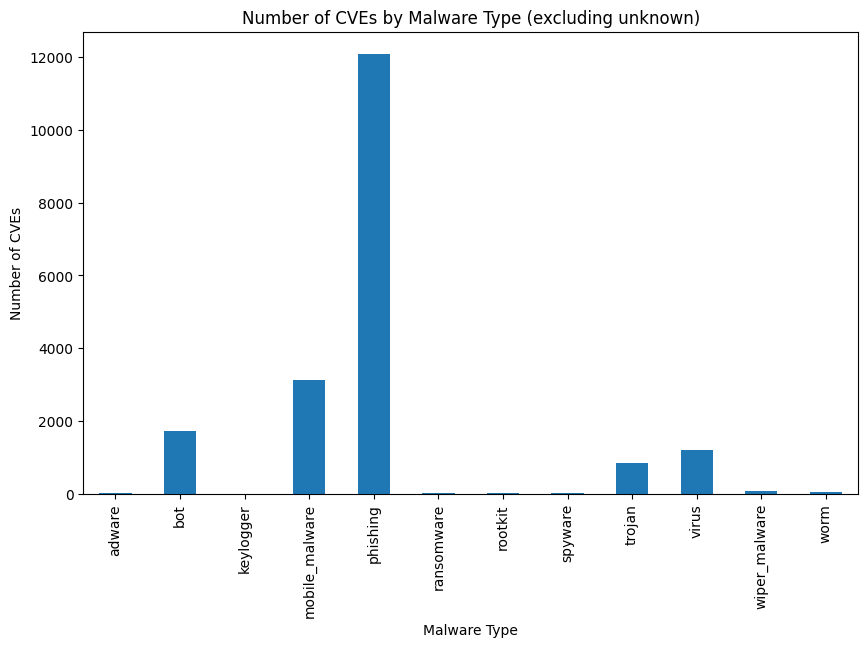

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from src.infrastructure.mongodb_cve_repository import MongoDBCVERepository

# TODO change me
CVES_WITH_PREDICTED_MALWARE_TYPE_COLLECTION = (
        "cves_with_predicted_malware_type" + "_20240804"
    )

cves_with_predicted_malware_type_repository = MongoDBCVERepository(collection_name=CVES_WITH_PREDICTED_MALWARE_TYPE_COLLECTION)

cves = cves_with_predicted_malware_type_repository.find_all()

df = pd.DataFrame(list(cves))

df["malware_type_final"] = np.where(
    (df["malware_type_x"].isna()) | (df["malware_type_x"] == "unknown"),
    df["predicted_malware_type"],
    df["malware_type_x"],
)

malware_counts = df.groupby('malware_type_final').size()

# Crear una gráfica de barras
plt.figure(figsize=(10, 6))
malware_counts.plot(kind='bar')

# Agregar etiquetas y título
plt.xlabel('Malware Type')
plt.ylabel('Number of CVEs')
plt.title('Number of CVEs by Malware Type')

# Mostrar la gráfica
plt.show()

df_filtered = df[df['malware_type_final'] != 'unknown']

malware_counts_filtered = df_filtered.groupby('malware_type_final').size()

# Crear una gráfica de barras
plt.figure(figsize=(10, 6))
malware_counts_filtered.plot(kind='bar')

# Agregar etiquetas y título
plt.xlabel('Malware Type')
plt.ylabel('Number of CVEs')
plt.title('Number of CVEs by Malware Type (excluding unknown)')

# Mostrar la gráfica
plt.show()

## CVEs by Malware Type over time

Now you can see how CVEs where created by Malware Type over time:

In [5]:
import numpy as np
import pandas as pd
from datetime import datetime

from config.logger import logger
from src.infrastructure.mongodb_cve_repository import MongoDBCVERepository

# TODO change me
CVES_WITH_PREDICTED_MALWARE_TYPE_COLLECTION = (
        "cves_with_predicted_malware_type" + "_20240804"
    )

cves_with_predicted_malware_type_repository = MongoDBCVERepository(
        collection_name=CVES_WITH_PREDICTED_MALWARE_TYPE_COLLECTION
    )

cves = cves_with_predicted_malware_type_repository.find_all()

df = pd.DataFrame(list(cves))

######

# TODO remove
converted_dates = []
for index, row in df.iterrows():
    date_published = row["date_published"]
    # Check if the input string contains 'T' and 'Z'
    if "T" in date_published and "Z" in date_published:
        if "." in date_published:
            # Parse the ISO 8601 format with microseconds and 'Z'
            dt = datetime.strptime(date_published, "%Y-%m-%dT%H:%M:%S.%fZ")
            # Format to the desired format
            formatted_datetime = dt.strftime("%Y-%m-%d %H:%M:%S")
        else:
            dt = datetime.strptime(date_published, "%Y-%m-%dT%H:%M:%SZ")
            # Format to the desired format
            formatted_datetime = dt.strftime("%Y-%m-%d %H:%M:%S")
    elif "T" in date_published and "Z" not in date_published:
        # Parse the ISO 8601 format with microseconds and 'Z'
        dt = datetime.strptime(date_published, "%Y-%m-%dT%H:%M:%S")
        # Format to the desired format
        formatted_datetime = dt.strftime("%Y-%m-%d %H:%M:%S")
    else:
        try:
            # If already in the correct format, simply return it
            dt = datetime.strptime(date_published, "%Y-%m-%d %H:%M:%S")
            formatted_datetime = dt.strftime("%Y-%m-%d %H:%M:%S")
        except ValueError:
            # Handle cases where the format doesn't match expected patterns
            raise ValueError("Unrecognized datetime format")
    converted_dates.append(formatted_datetime)

df["date_published"] = converted_dates

try:
    df["date_published"] = pd.to_datetime(df["date_published"], errors="coerce")

except Exception as e:
    logger.error("An error occurred:", e)

non_datetime_values = df[df["date_published"].isna()]["date_published"]

if not non_datetime_values.empty:
    logger.error("The following rows could not be converted to datetime:")
    logger.error(df[df["date_published"].isna()])

# Step 3: Optionally, remove or handle rows with NaT values
df = df.dropna(subset=["date_published"])

if not pd.api.types.is_datetime64_any_dtype(df["date_published"]):
    logger.error("Error: 'date_published' is still not in datetime format after handling.")
else:
    logger.debug("Date_published successfully converted to datetime format.")

for index, row in df.iterrows():
    if pd.isna(row["date_published"]):  # Check if conversion resulted in NaT
        logger.error(
            f"Row {index} with date_published value '{row['date_published']}' could not be converted."
        )
    if not isinstance(row["date_published"], pd.Timestamp):
        logger.error(row)

#####

df["malware_type_final"] = np.where(
    (df["malware_type_x"].isna()) | (df["malware_type_x"] == "unknown"),
    df["predicted_malware_type"],
    df["malware_type_x"],
)

# Group by date and malware_type to count occurrences
grouped_df = (
    df.groupby([df["date_published"].dt.to_period("M"), "malware_type_final"])
    .size()
    .reset_index(name="count")
)

# Convert to timestamp for time series models
grouped_df["date_published"] = grouped_df["date_published"].dt.to_timestamp()

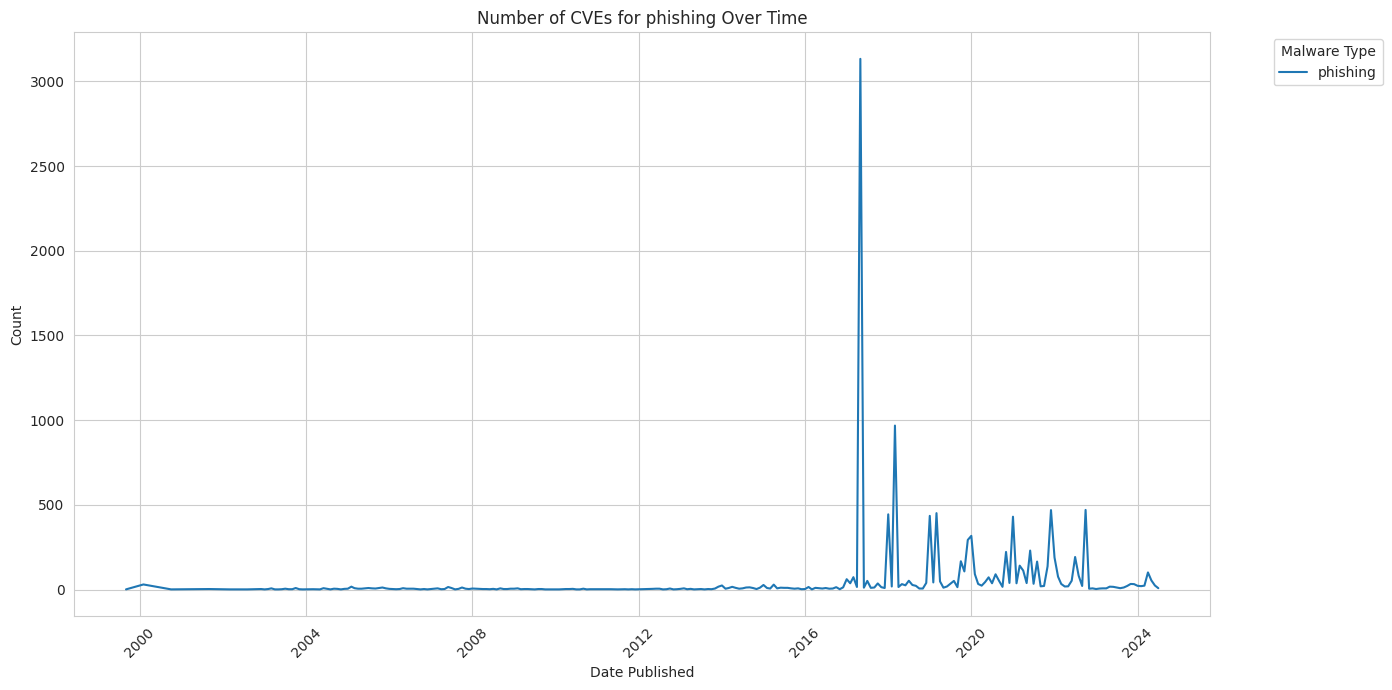

<Figure size 640x480 with 0 Axes>

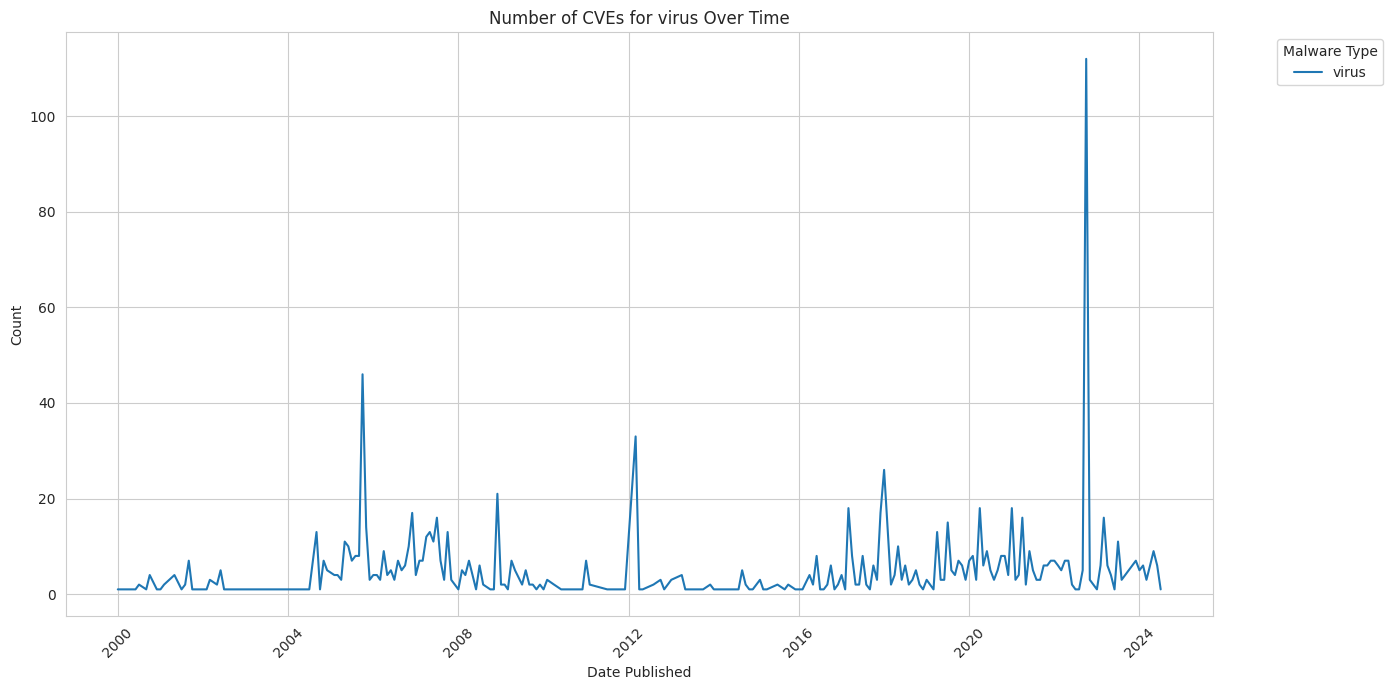

<Figure size 640x480 with 0 Axes>

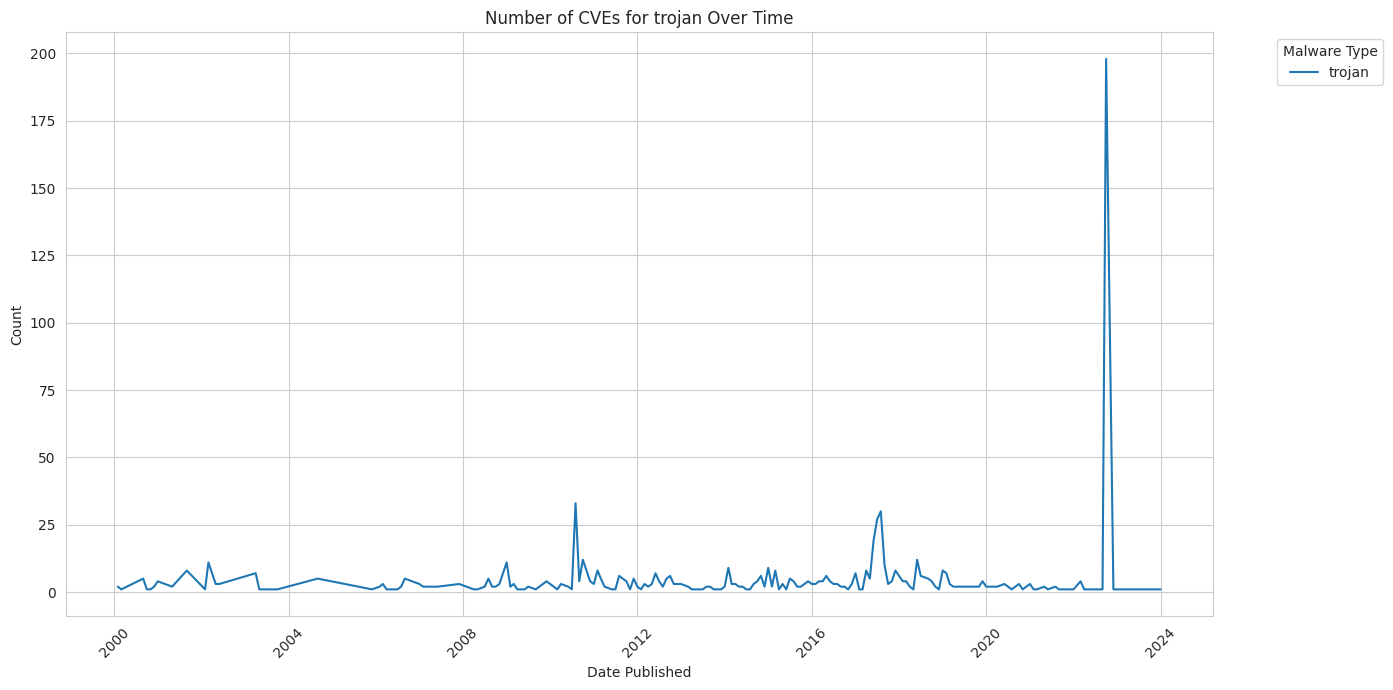

<Figure size 640x480 with 0 Axes>

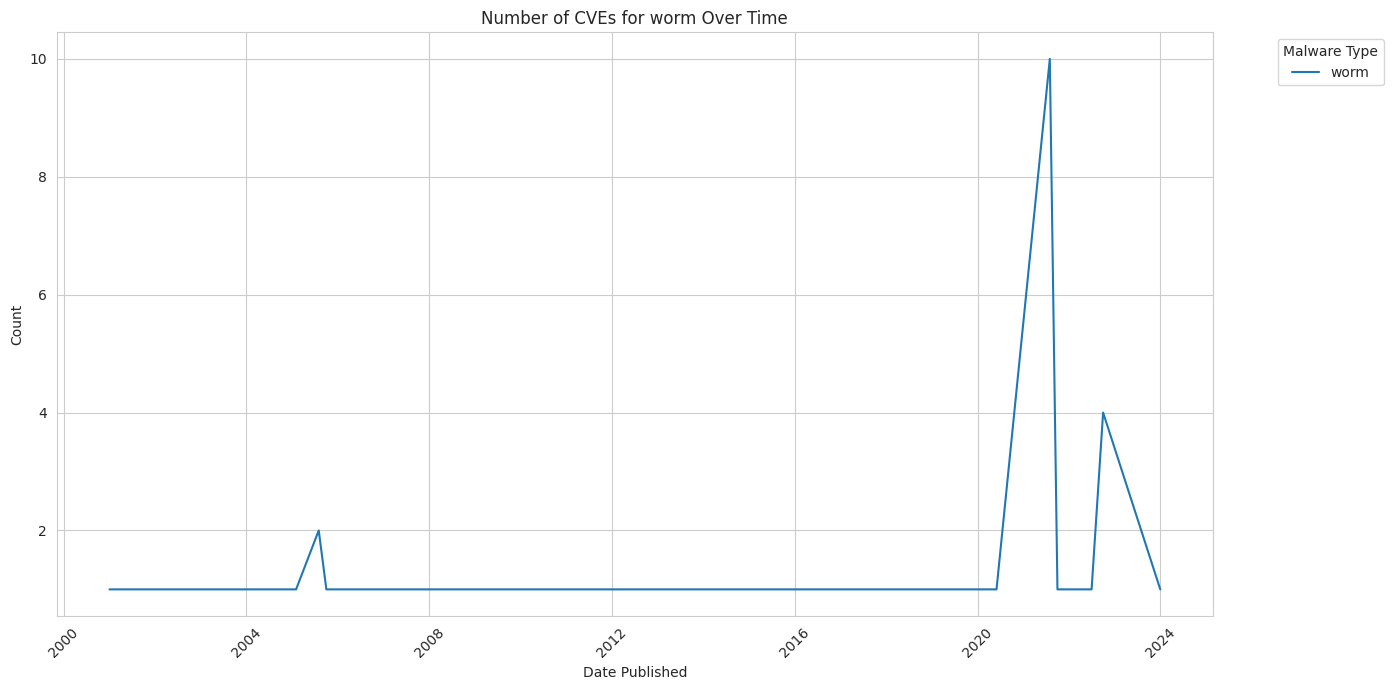

<Figure size 640x480 with 0 Axes>

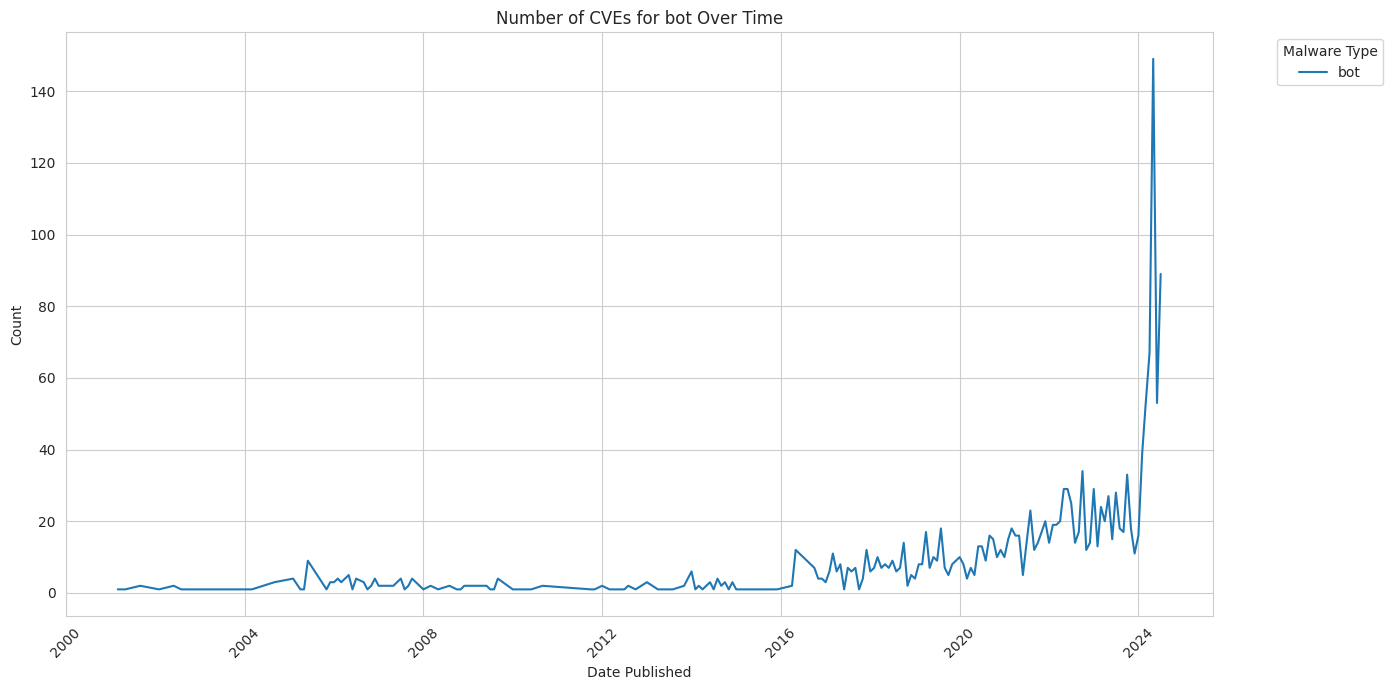

<Figure size 640x480 with 0 Axes>

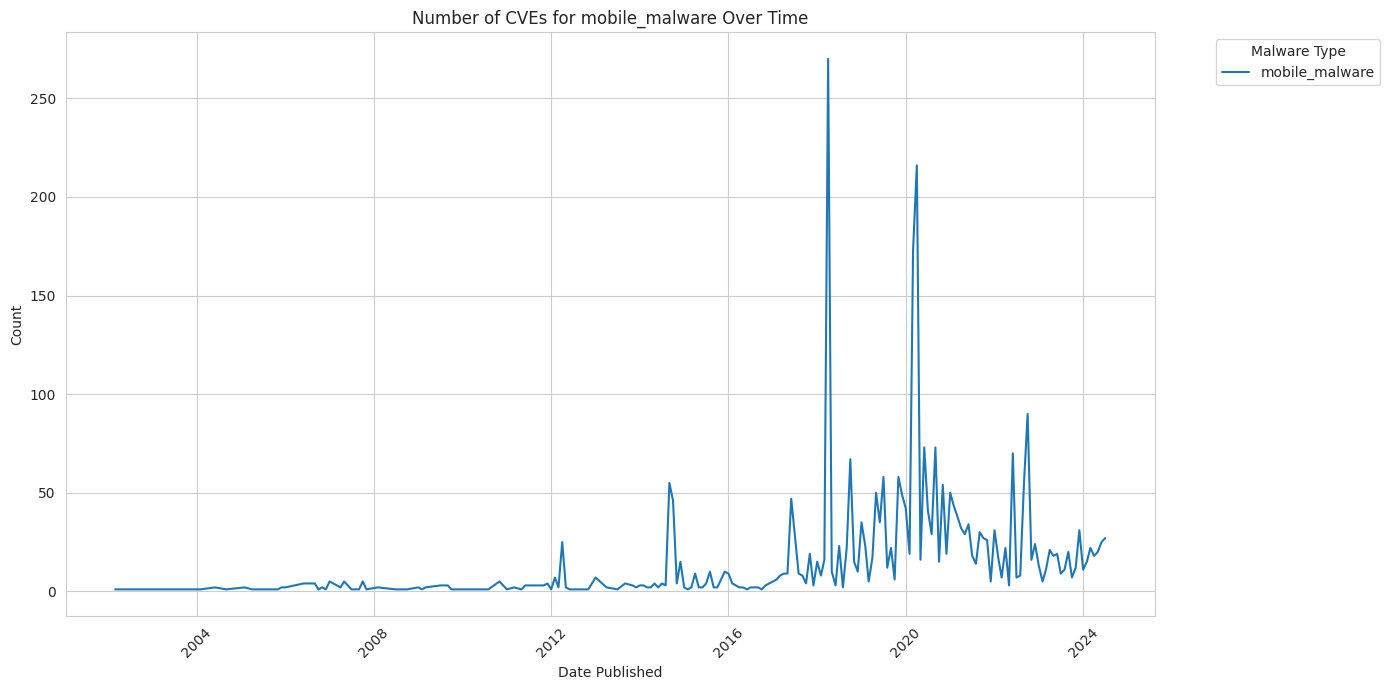

<Figure size 640x480 with 0 Axes>

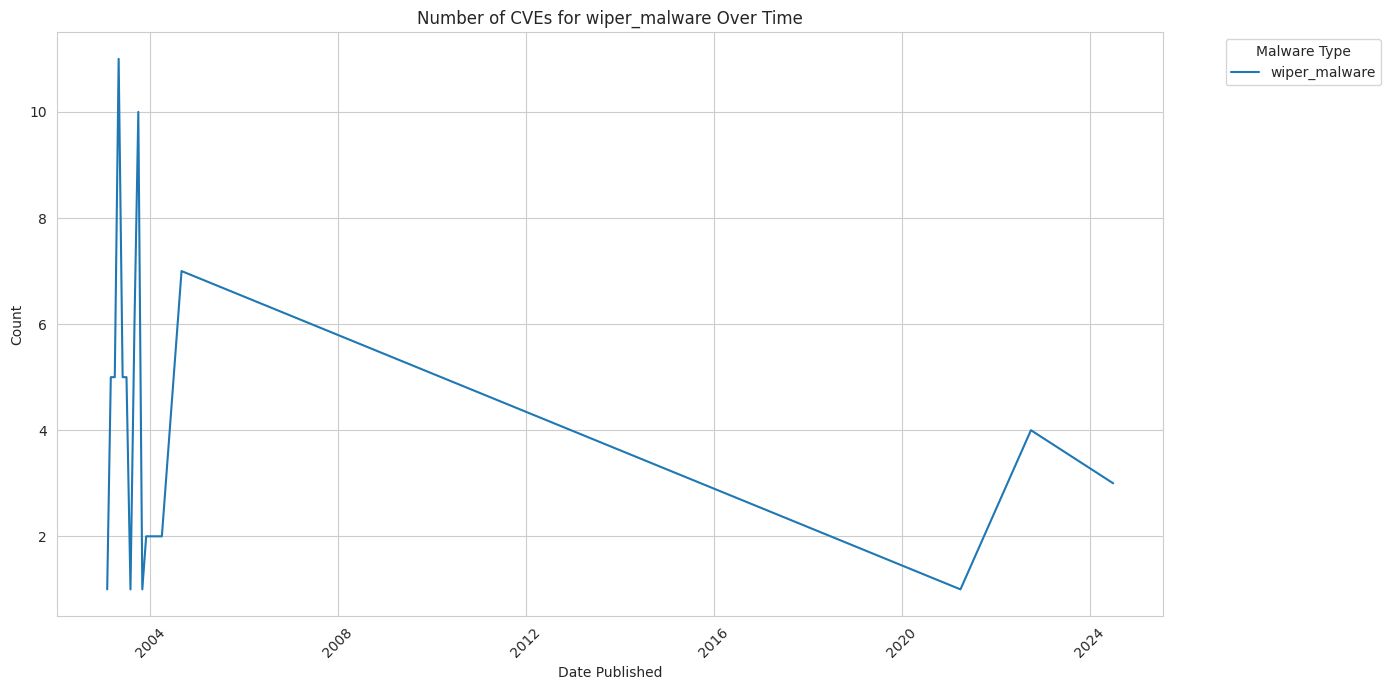

<Figure size 640x480 with 0 Axes>

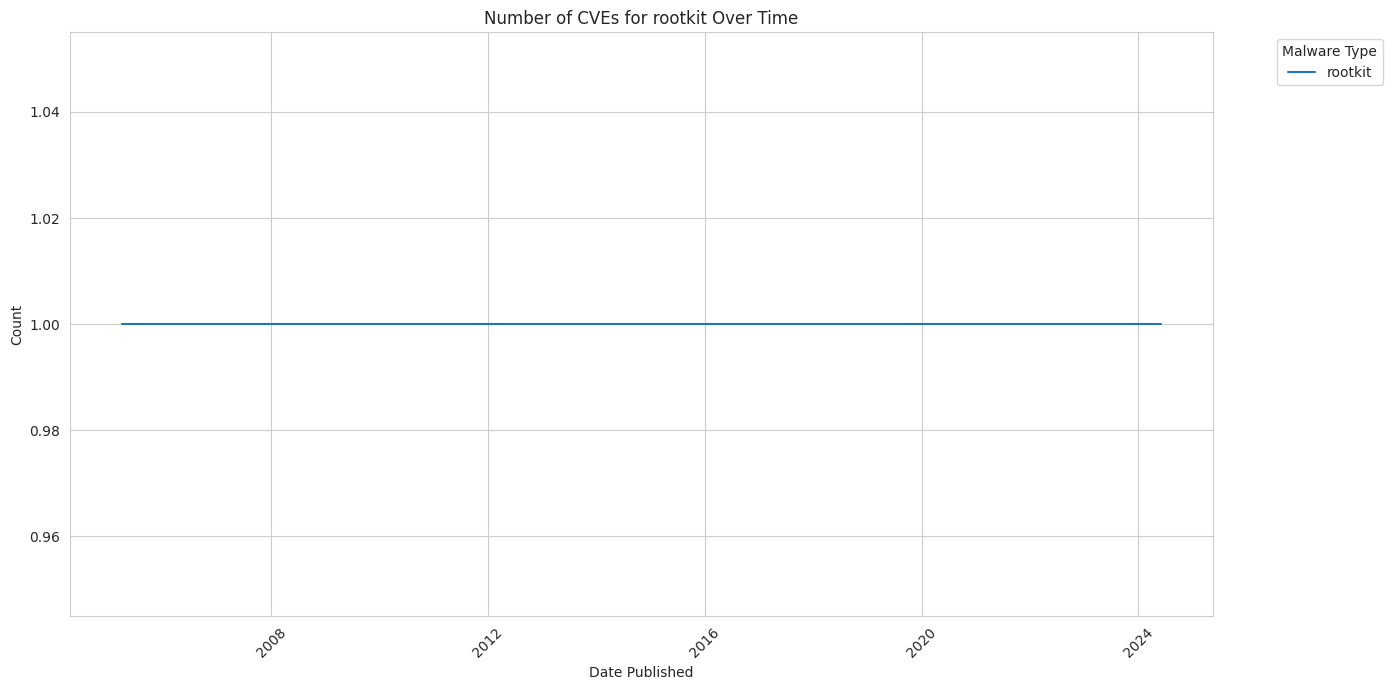

<Figure size 640x480 with 0 Axes>

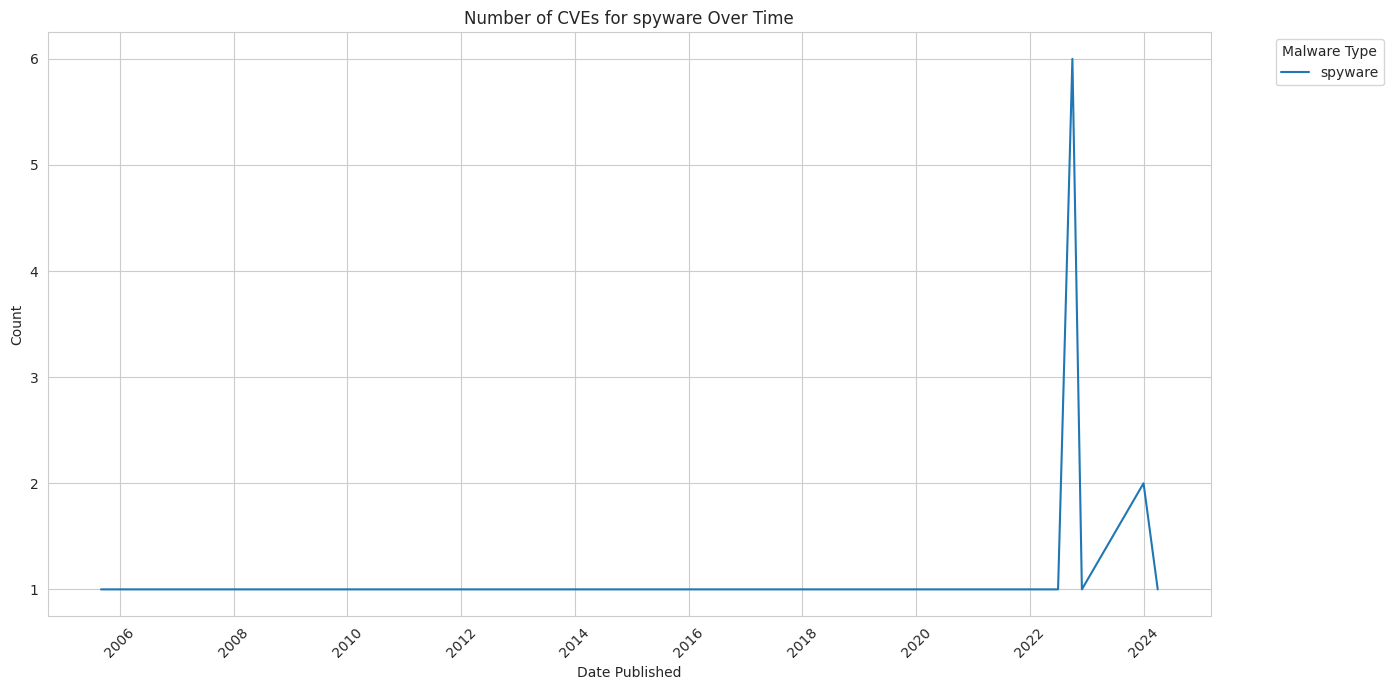

<Figure size 640x480 with 0 Axes>

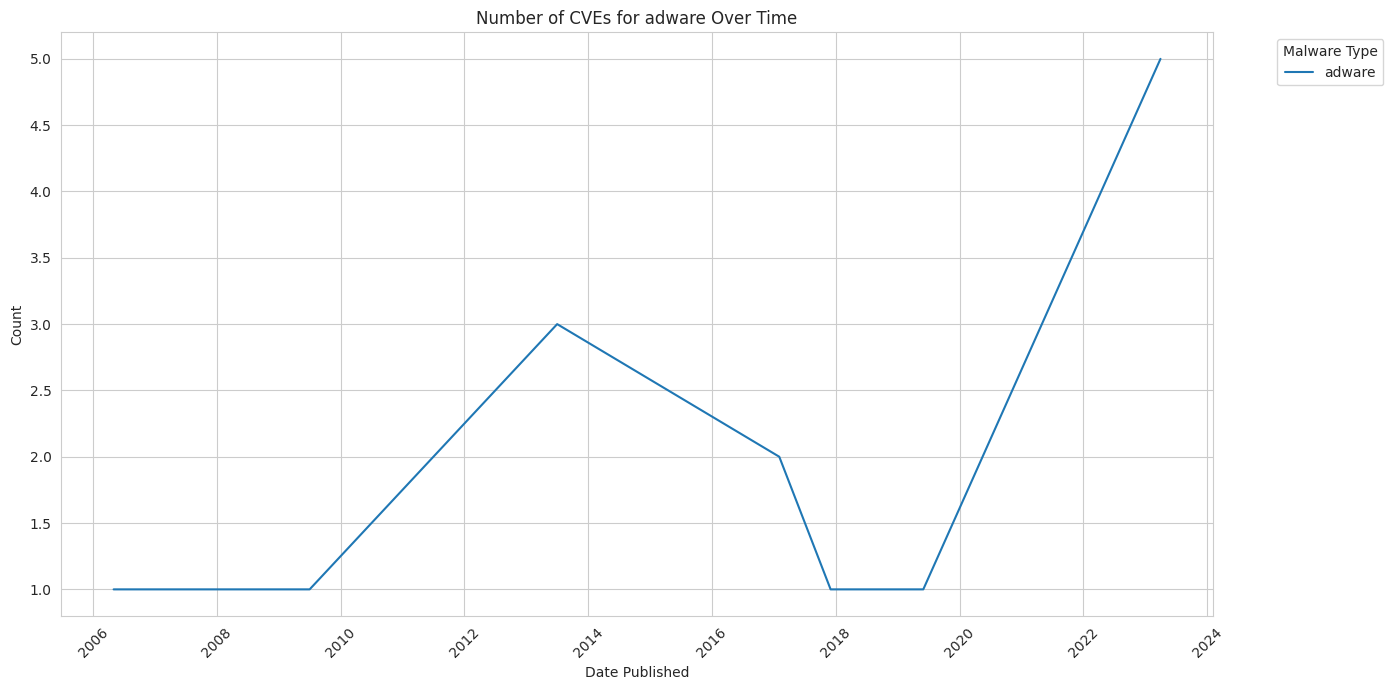

<Figure size 640x480 with 0 Axes>

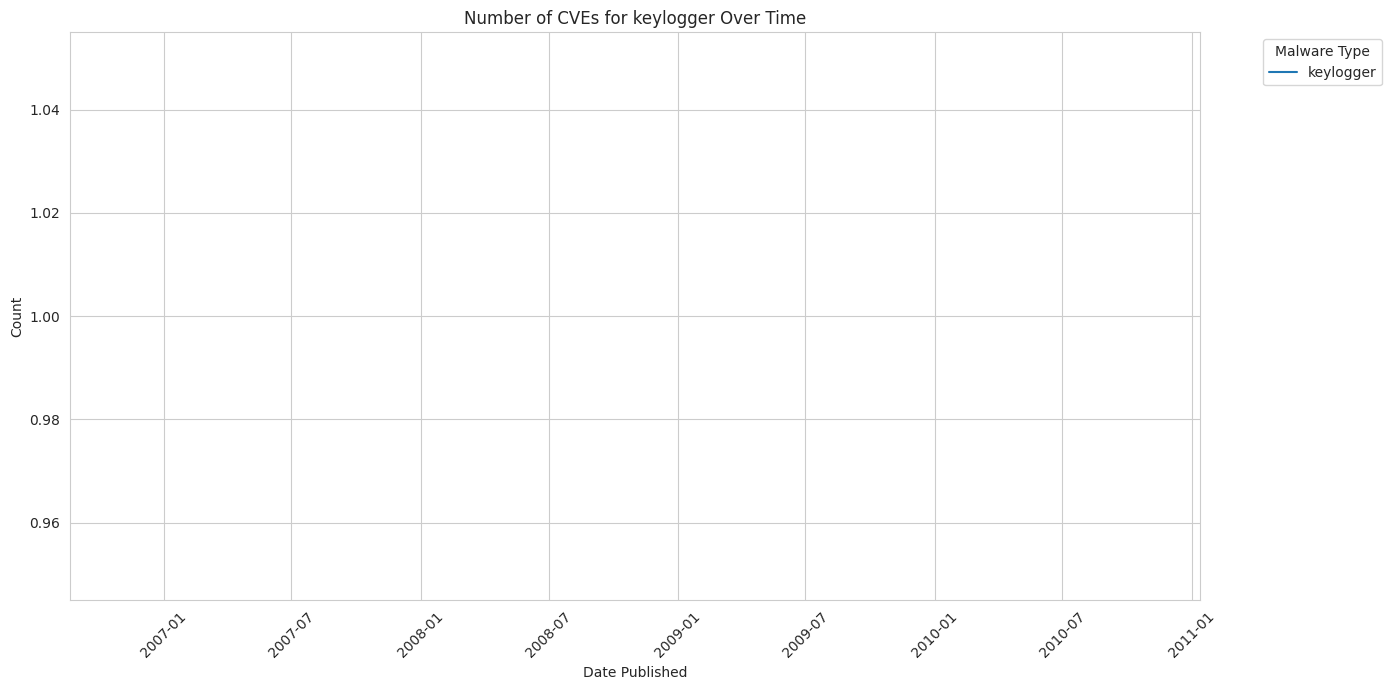

<Figure size 640x480 with 0 Axes>

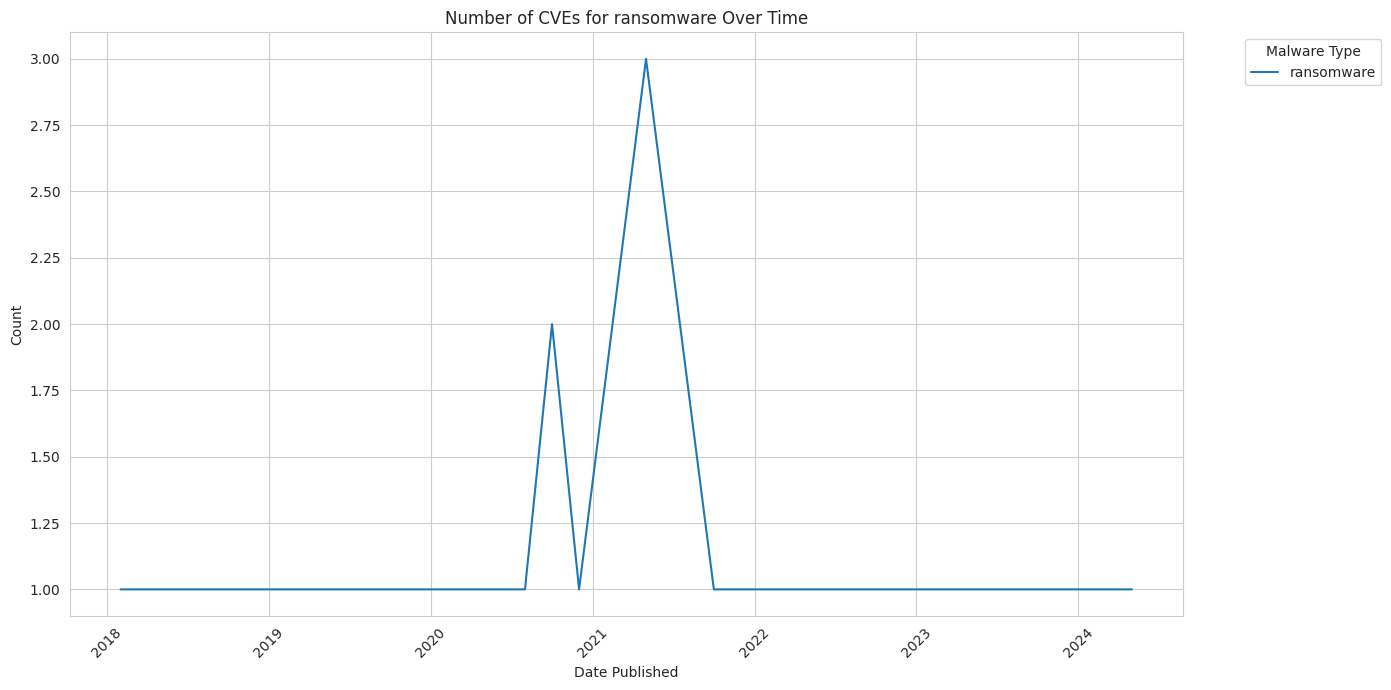

<Figure size 640x480 with 0 Axes>

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# visualize data
# Set the plot style
sns.set_style("whitegrid")

# Generate and save a plot for each malware type
for malware_type in grouped_df["malware_type_final"].unique():
    # Filter data for the current malware type
    df_malware = grouped_df[grouped_df["malware_type_final"] == malware_type]

    # Plot the number of CVEs over time for this malware type
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=df_malware, x="date_published", y="count", hue="malware_type_final")
    plt.title(f"Number of CVEs for {malware_type} Over Time")
    plt.xlabel("Date Published")
    plt.ylabel("Count")
    plt.legend(title="Malware Type", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Optionally show the plot
    plt.show()

    # Clear the figure to avoid overlapping plots in the next iteration
    plt.clf()

## Forecasting CVEs by Malware Type

Now, using a forecasting model we try to predict CVEs by Malware Type over time.

### Forecasting 1 year from now
This is the result:

[2024-08-11 16:42:24.730] DEBUG [134610428276736] - input tempfile: /tmp/tmpcuqfelo_/o4xomlwn.json
[2024-08-11 16:42:24.774] DEBUG [134610428276736] - input tempfile: /tmp/tmpcuqfelo_/iqlac4_6.json
[2024-08-11 16:42:24.777] DEBUG [134610428276736] - idx 0
[2024-08-11 16:42:24.779] DEBUG [134610428276736] - running CmdStan, num_threads: None
[2024-08-11 16:42:24.781] DEBUG [134610428276736] - CmdStan args: ['/home/ggimeno/dev/git/github/others/ai-osint-malware-analysis/.venv/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79405', 'data', 'file=/tmp/tmpcuqfelo_/o4xomlwn.json', 'init=/tmp/tmpcuqfelo_/iqlac4_6.json', 'output', 'file=/tmp/tmpcuqfelo_/prophet_models7pelfzn/prophet_model-20240811164224.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:42:24 - cmdstanpy - INFO - Chain [1] start processing
[2024-08-11 16:42:24.783] INFO [134610428276736] - Chain [1] start processing
16:42:24 - cmdstanpy - INFO - Chain [1] done processing
[2024-08-1

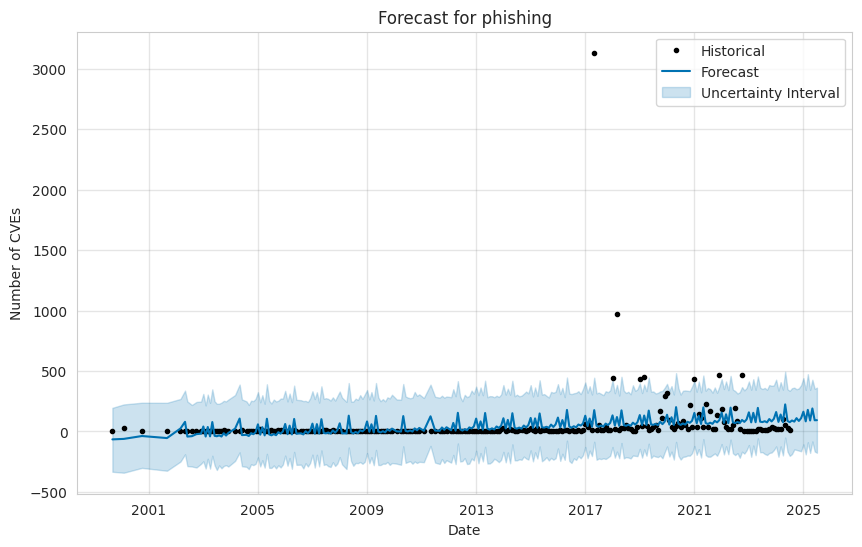

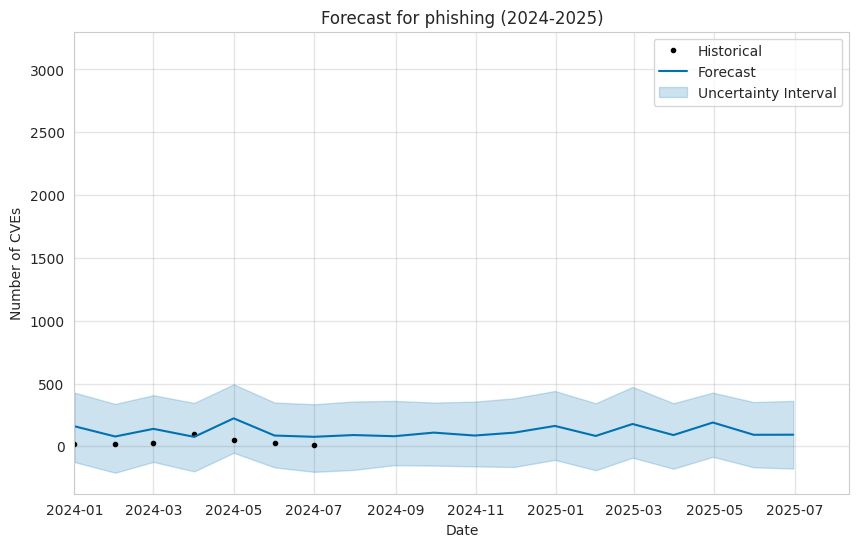

[2024-08-11 16:42:26.733] DEBUG [134610428276736] - input tempfile: /tmp/tmpcuqfelo_/abwlfnzy.json
[2024-08-11 16:42:26.766] DEBUG [134610428276736] - input tempfile: /tmp/tmpcuqfelo_/q9f6bnsp.json
[2024-08-11 16:42:26.769] DEBUG [134610428276736] - idx 0
[2024-08-11 16:42:26.771] DEBUG [134610428276736] - running CmdStan, num_threads: None
[2024-08-11 16:42:26.775] DEBUG [134610428276736] - CmdStan args: ['/home/ggimeno/dev/git/github/others/ai-osint-malware-analysis/.venv/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33397', 'data', 'file=/tmp/tmpcuqfelo_/abwlfnzy.json', 'init=/tmp/tmpcuqfelo_/q9f6bnsp.json', 'output', 'file=/tmp/tmpcuqfelo_/prophet_modelj9dxnaj3/prophet_model-20240811164226.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:42:26 - cmdstanpy - INFO - Chain [1] start processing
[2024-08-11 16:42:26.777] INFO [134610428276736] - Chain [1] start processing
16:42:26 - cmdstanpy - INFO - Chain [1] done processing
[2024-08-1

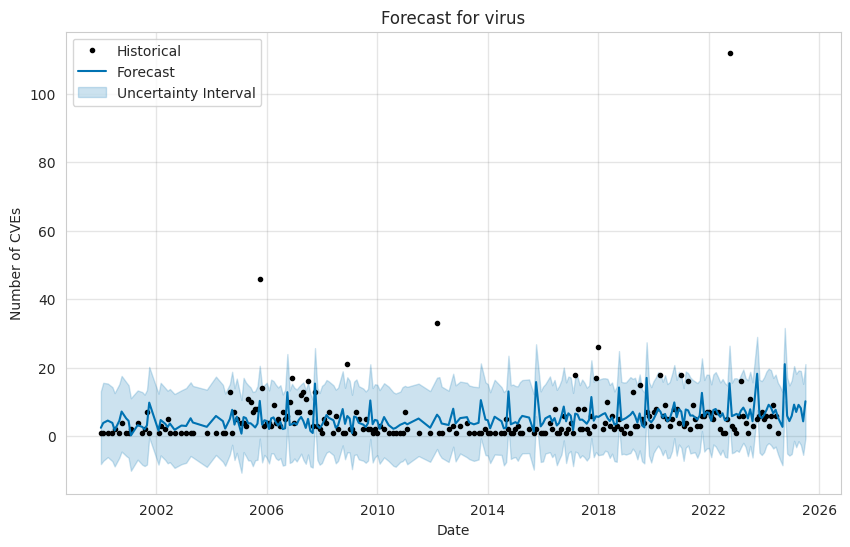

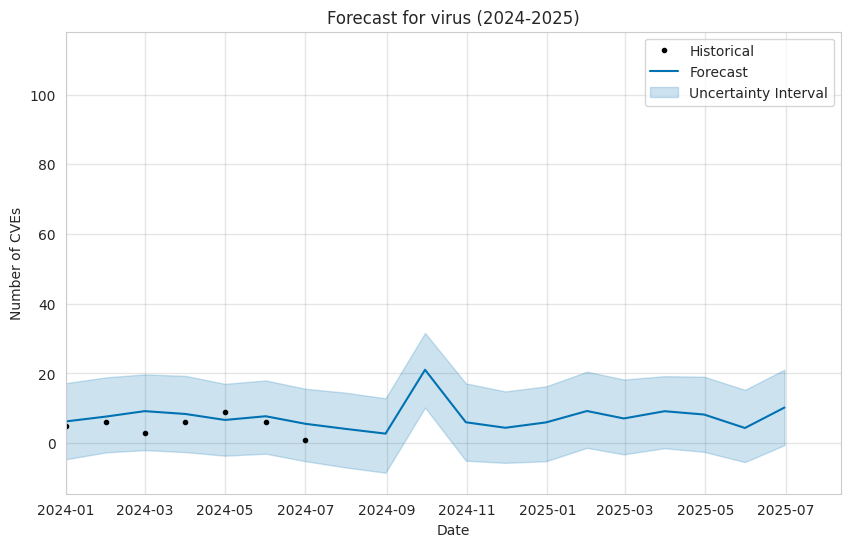

[2024-08-11 16:42:28.661] DEBUG [134610428276736] - input tempfile: /tmp/tmpcuqfelo_/ty5ibv3v.json
[2024-08-11 16:42:28.683] DEBUG [134610428276736] - input tempfile: /tmp/tmpcuqfelo_/1j1t_sok.json
[2024-08-11 16:42:28.687] DEBUG [134610428276736] - idx 0
[2024-08-11 16:42:28.690] DEBUG [134610428276736] - running CmdStan, num_threads: None
[2024-08-11 16:42:28.691] DEBUG [134610428276736] - CmdStan args: ['/home/ggimeno/dev/git/github/others/ai-osint-malware-analysis/.venv/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30456', 'data', 'file=/tmp/tmpcuqfelo_/ty5ibv3v.json', 'init=/tmp/tmpcuqfelo_/1j1t_sok.json', 'output', 'file=/tmp/tmpcuqfelo_/prophet_modelpezhjst8/prophet_model-20240811164228.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:42:28 - cmdstanpy - INFO - Chain [1] start processing
[2024-08-11 16:42:28.692] INFO [134610428276736] - Chain [1] start processing
16:42:28 - cmdstanpy - INFO - Chain [1] done processing
[2024-08-1

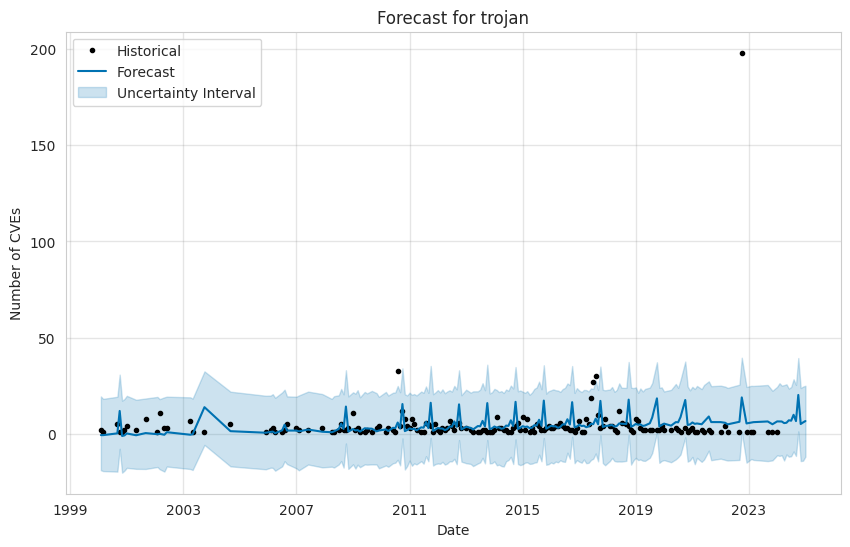

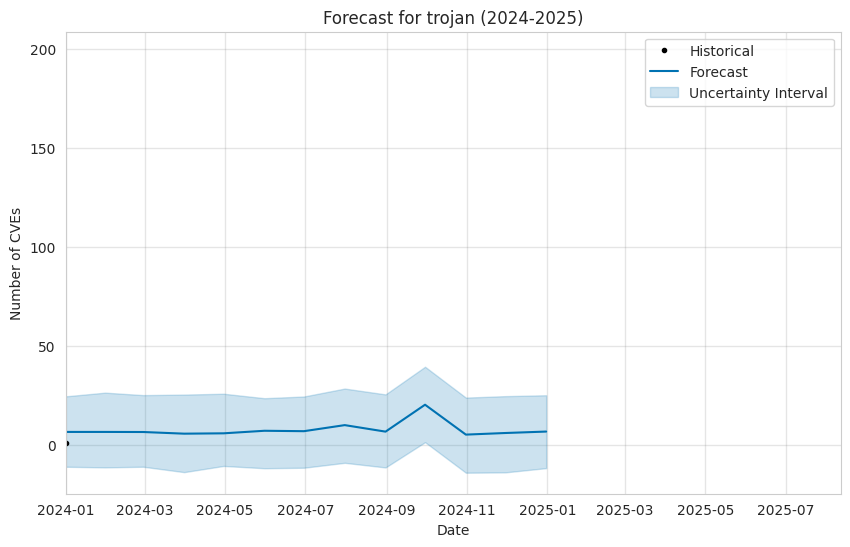

[2024-08-11 16:42:30.428] INFO [134610428276736] - n_changepoints greater than number of observations. Using 21.
[2024-08-11 16:42:30.434] DEBUG [134610428276736] - input tempfile: /tmp/tmpcuqfelo_/jsll5u7m.json
[2024-08-11 16:42:30.440] DEBUG [134610428276736] - input tempfile: /tmp/tmpcuqfelo_/u_qfwcyi.json
[2024-08-11 16:42:30.442] DEBUG [134610428276736] - idx 0
[2024-08-11 16:42:30.444] DEBUG [134610428276736] - running CmdStan, num_threads: None
[2024-08-11 16:42:30.445] DEBUG [134610428276736] - CmdStan args: ['/home/ggimeno/dev/git/github/others/ai-osint-malware-analysis/.venv/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78352', 'data', 'file=/tmp/tmpcuqfelo_/jsll5u7m.json', 'init=/tmp/tmpcuqfelo_/u_qfwcyi.json', 'output', 'file=/tmp/tmpcuqfelo_/prophet_modellpvwb_5m/prophet_model-20240811164230.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:42:30 - cmdstanpy - INFO - Chain [1] start processing
[2024-08-11 16:42:30.446] INFO

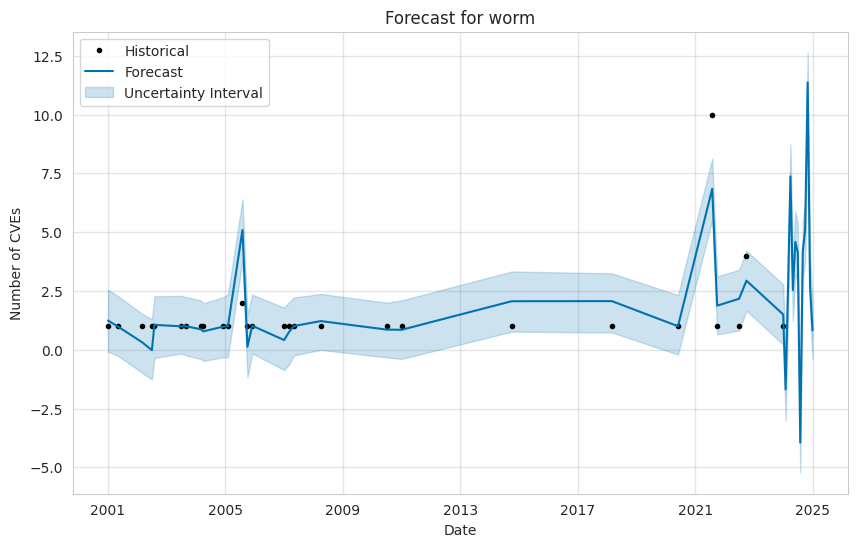

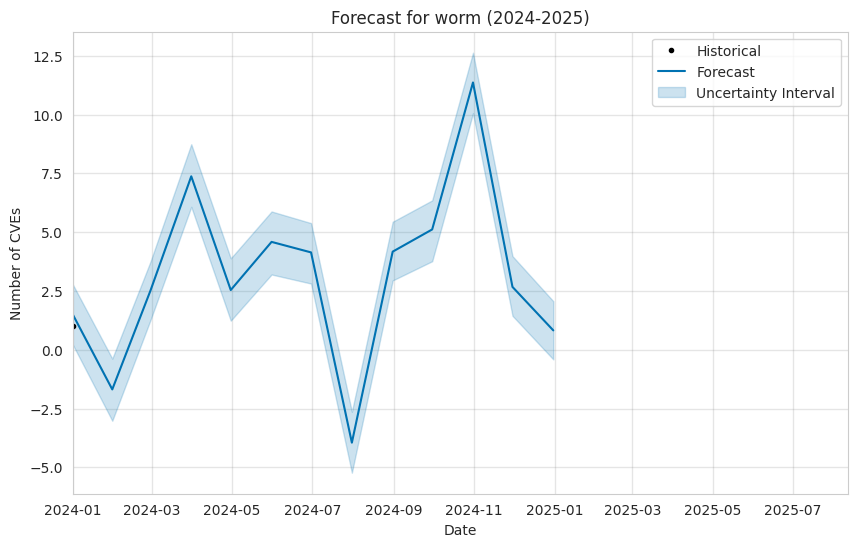

[2024-08-11 16:42:32.099] DEBUG [134610428276736] - input tempfile: /tmp/tmpcuqfelo_/yv59vt0o.json
[2024-08-11 16:42:32.129] DEBUG [134610428276736] - input tempfile: /tmp/tmpcuqfelo_/hgc909cm.json
[2024-08-11 16:42:32.132] DEBUG [134610428276736] - idx 0
[2024-08-11 16:42:32.134] DEBUG [134610428276736] - running CmdStan, num_threads: None
[2024-08-11 16:42:32.136] DEBUG [134610428276736] - CmdStan args: ['/home/ggimeno/dev/git/github/others/ai-osint-malware-analysis/.venv/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45596', 'data', 'file=/tmp/tmpcuqfelo_/yv59vt0o.json', 'init=/tmp/tmpcuqfelo_/hgc909cm.json', 'output', 'file=/tmp/tmpcuqfelo_/prophet_model7osghf2e/prophet_model-20240811164232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:42:32 - cmdstanpy - INFO - Chain [1] start processing
[2024-08-11 16:42:32.137] INFO [134610428276736] - Chain [1] start processing
16:42:32 - cmdstanpy - INFO - Chain [1] done processing
[2024-08-1

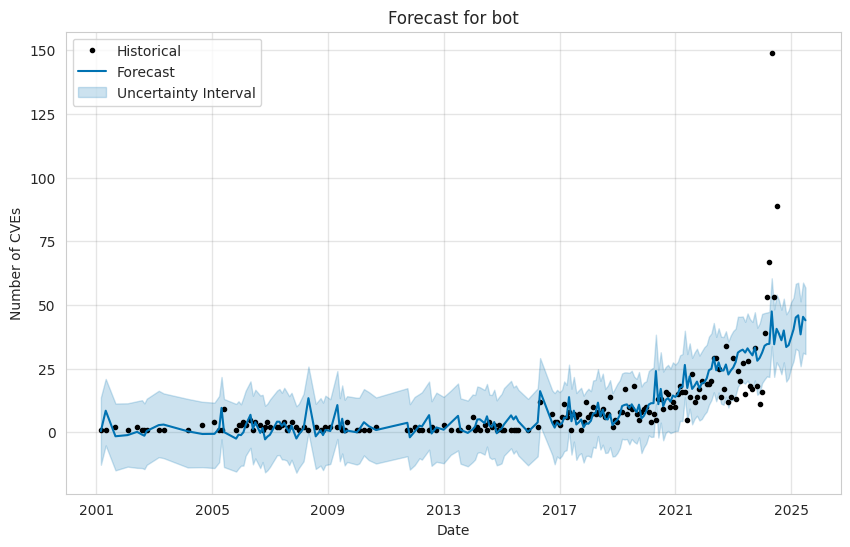

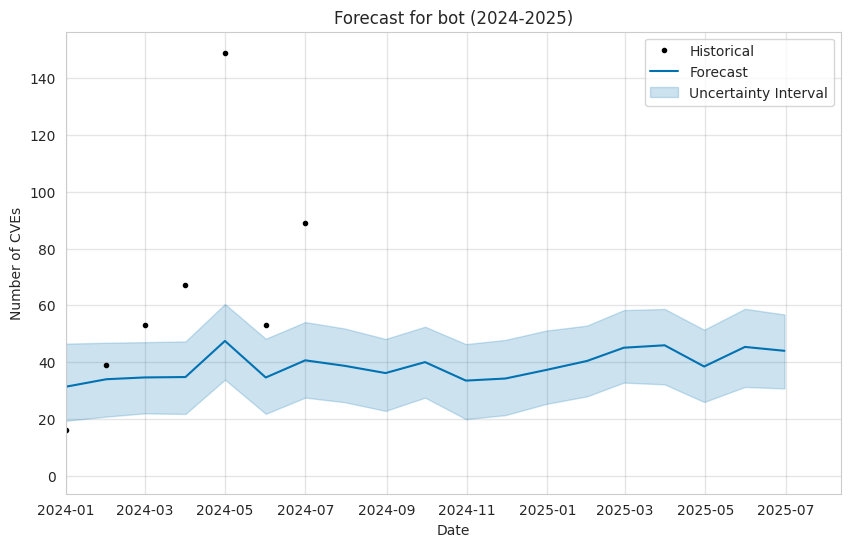

[2024-08-11 16:42:33.770] DEBUG [134610428276736] - input tempfile: /tmp/tmpcuqfelo_/58girxfb.json
[2024-08-11 16:42:33.793] DEBUG [134610428276736] - input tempfile: /tmp/tmpcuqfelo_/z9238v8s.json
[2024-08-11 16:42:33.796] DEBUG [134610428276736] - idx 0
[2024-08-11 16:42:33.797] DEBUG [134610428276736] - running CmdStan, num_threads: None
[2024-08-11 16:42:33.799] DEBUG [134610428276736] - CmdStan args: ['/home/ggimeno/dev/git/github/others/ai-osint-malware-analysis/.venv/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43636', 'data', 'file=/tmp/tmpcuqfelo_/58girxfb.json', 'init=/tmp/tmpcuqfelo_/z9238v8s.json', 'output', 'file=/tmp/tmpcuqfelo_/prophet_modelfjufcscz/prophet_model-20240811164233.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:42:33 - cmdstanpy - INFO - Chain [1] start processing
[2024-08-11 16:42:33.801] INFO [134610428276736] - Chain [1] start processing
16:42:33 - cmdstanpy - INFO - Chain [1] done processing
[2024-08-1

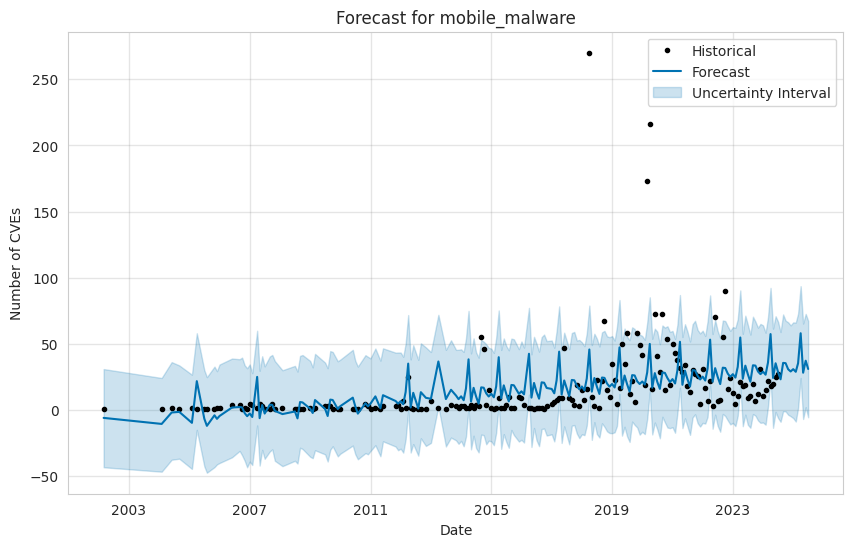

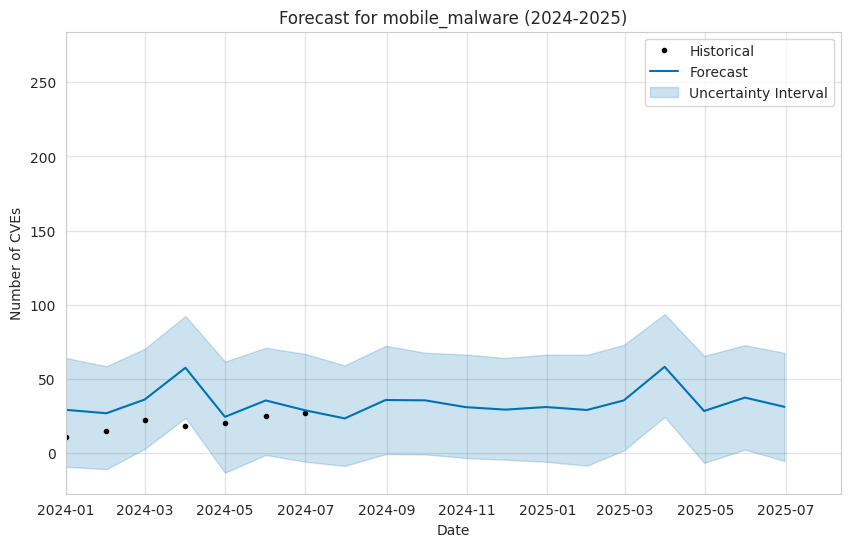

[2024-08-11 16:42:35.295] INFO [134610428276736] - n_changepoints greater than number of observations. Using 12.
[2024-08-11 16:42:35.301] DEBUG [134610428276736] - input tempfile: /tmp/tmpcuqfelo_/os1zay0o.json
[2024-08-11 16:42:35.306] DEBUG [134610428276736] - input tempfile: /tmp/tmpcuqfelo_/ilb1lzjg.json
[2024-08-11 16:42:35.310] DEBUG [134610428276736] - idx 0
[2024-08-11 16:42:35.312] DEBUG [134610428276736] - running CmdStan, num_threads: None
[2024-08-11 16:42:35.313] DEBUG [134610428276736] - CmdStan args: ['/home/ggimeno/dev/git/github/others/ai-osint-malware-analysis/.venv/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5130', 'data', 'file=/tmp/tmpcuqfelo_/os1zay0o.json', 'init=/tmp/tmpcuqfelo_/ilb1lzjg.json', 'output', 'file=/tmp/tmpcuqfelo_/prophet_modeloyvkvrxc/prophet_model-20240811164235.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:42:35 - cmdstanpy - INFO - Chain [1] start processing
[2024-08-11 16:42:35.314] INFO 

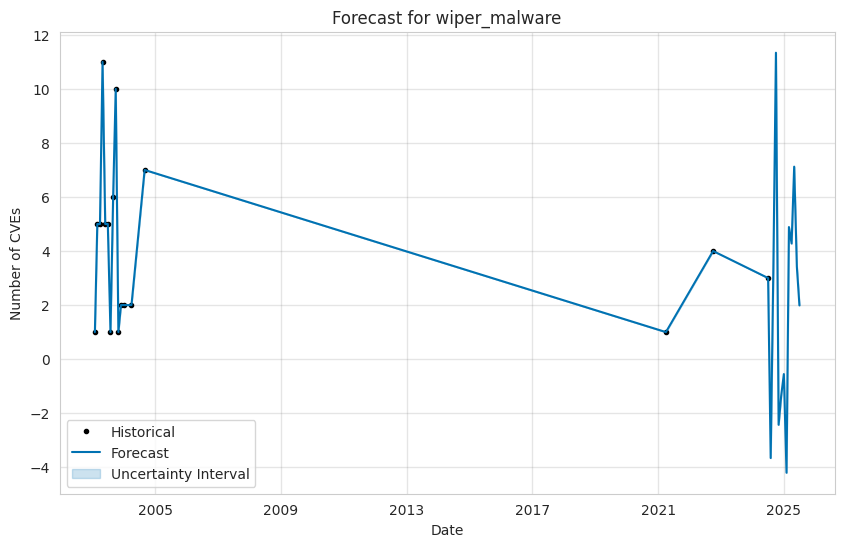

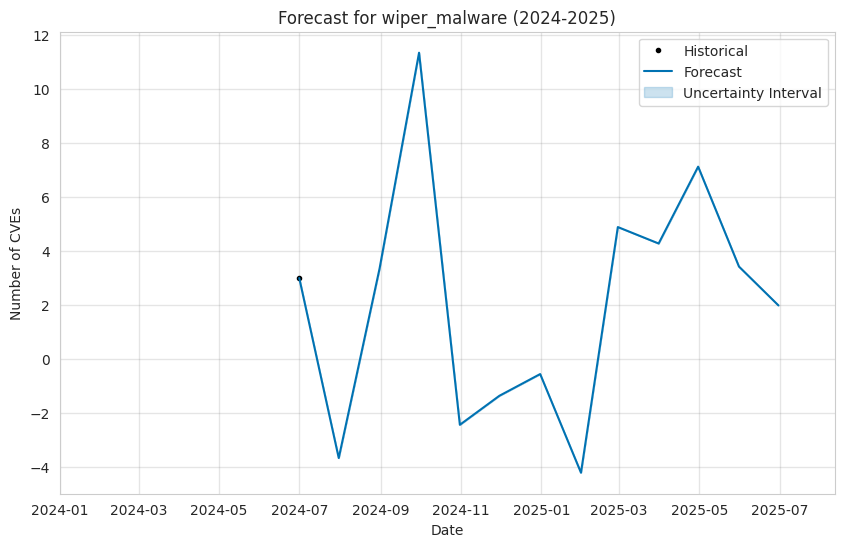

[2024-08-11 16:42:38.108] INFO [134610428276736] - n_changepoints greater than number of observations. Using 5.
/home/ggimeno/dev/git/github/others/ai-osint-malware-analysis/.venv/lib/python3.10/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
/home/ggimeno/dev/git/github/others/ai-osint-malware-analysis/.venv/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/ggimeno/dev/git/github/others/ai-osint-malware-analysis/.venv/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Serie

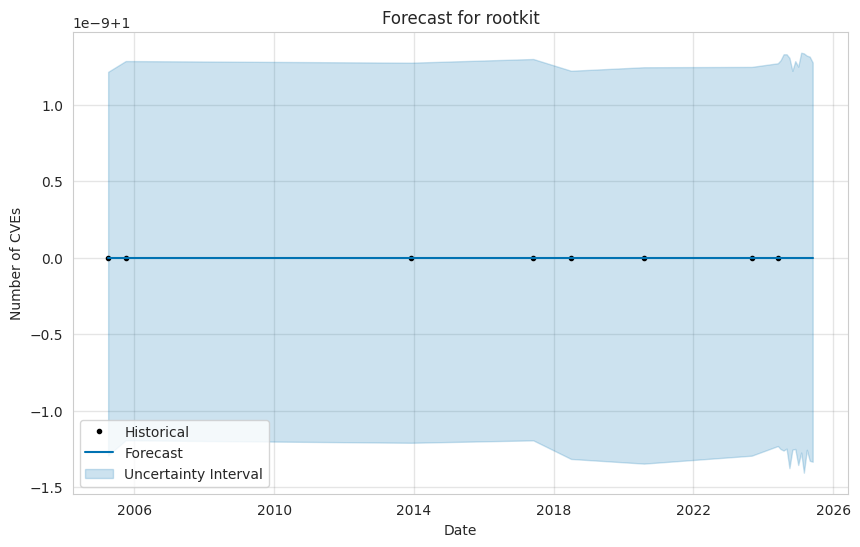

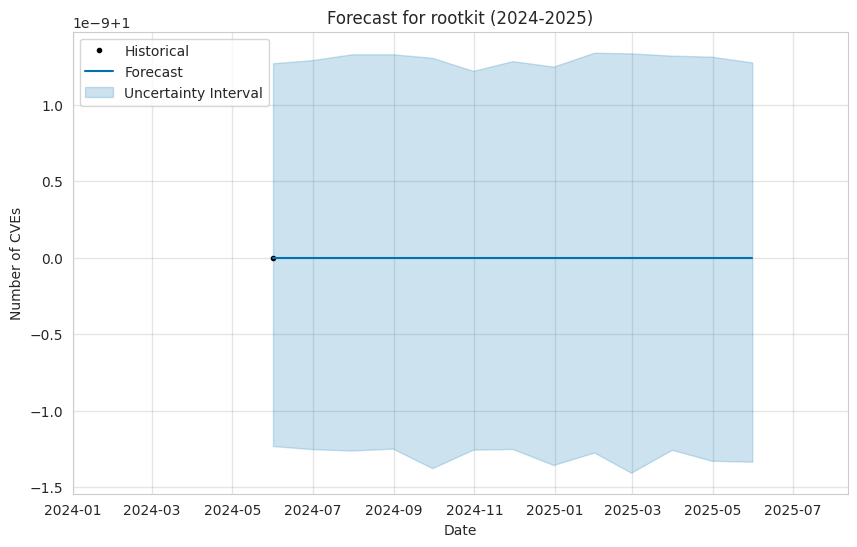

[2024-08-11 16:42:39.856] INFO [134610428276736] - n_changepoints greater than number of observations. Using 9.
[2024-08-11 16:42:39.862] DEBUG [134610428276736] - input tempfile: /tmp/tmpcuqfelo_/5zailq_2.json
[2024-08-11 16:42:39.867] DEBUG [134610428276736] - input tempfile: /tmp/tmpcuqfelo_/deaq0oid.json
[2024-08-11 16:42:39.870] DEBUG [134610428276736] - idx 0
[2024-08-11 16:42:39.871] DEBUG [134610428276736] - running CmdStan, num_threads: None
[2024-08-11 16:42:39.872] DEBUG [134610428276736] - CmdStan args: ['/home/ggimeno/dev/git/github/others/ai-osint-malware-analysis/.venv/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53959', 'data', 'file=/tmp/tmpcuqfelo_/5zailq_2.json', 'init=/tmp/tmpcuqfelo_/deaq0oid.json', 'output', 'file=/tmp/tmpcuqfelo_/prophet_modelv90tubhp/prophet_model-20240811164239.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:42:39 - cmdstanpy - INFO - Chain [1] start processing
[2024-08-11 16:42:39.874] INFO 

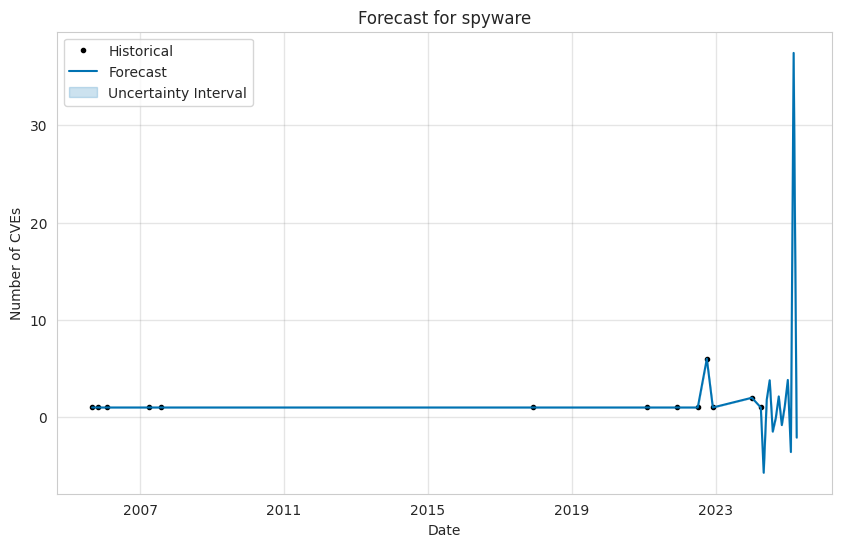

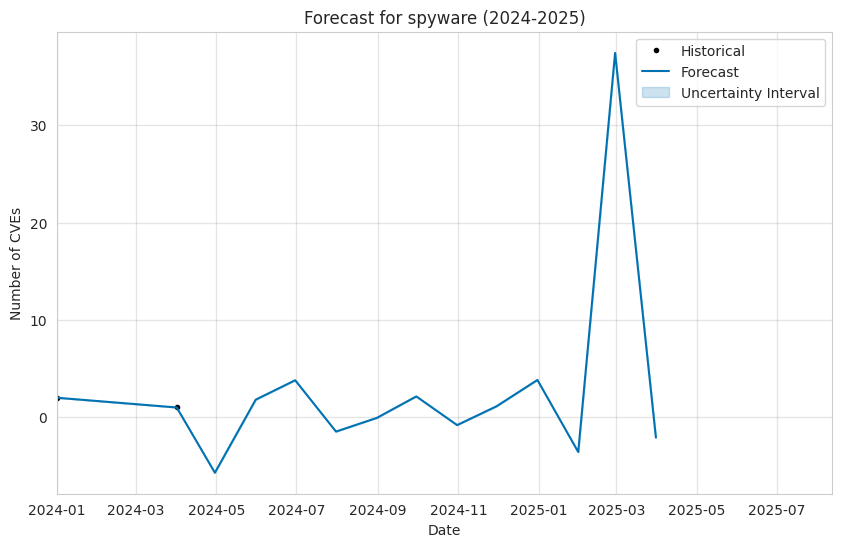

[2024-08-11 16:42:48.758] INFO [134610428276736] - n_changepoints greater than number of observations. Using 4.
[2024-08-11 16:42:48.766] DEBUG [134610428276736] - input tempfile: /tmp/tmpcuqfelo_/ai977lu0.json
[2024-08-11 16:42:48.771] DEBUG [134610428276736] - input tempfile: /tmp/tmpcuqfelo_/hv1nsk8e.json
[2024-08-11 16:42:48.775] DEBUG [134610428276736] - idx 0
[2024-08-11 16:42:48.778] DEBUG [134610428276736] - running CmdStan, num_threads: None
[2024-08-11 16:42:48.780] DEBUG [134610428276736] - CmdStan args: ['/home/ggimeno/dev/git/github/others/ai-osint-malware-analysis/.venv/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31305', 'data', 'file=/tmp/tmpcuqfelo_/ai977lu0.json', 'init=/tmp/tmpcuqfelo_/hv1nsk8e.json', 'output', 'file=/tmp/tmpcuqfelo_/prophet_modeldpc84e0y/prophet_model-20240811164248.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:42:48 - cmdstanpy - INFO - Chain [1] start processing
[2024-08-11 16:42:48.782] INFO 

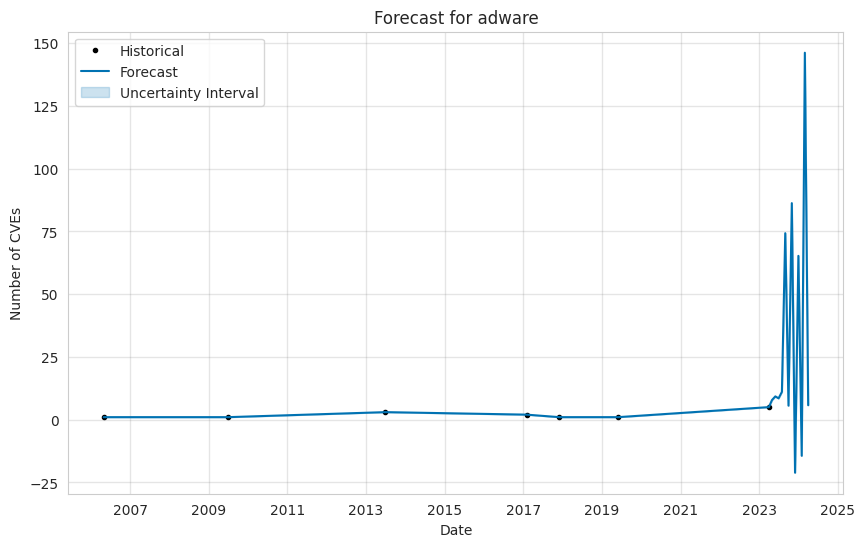

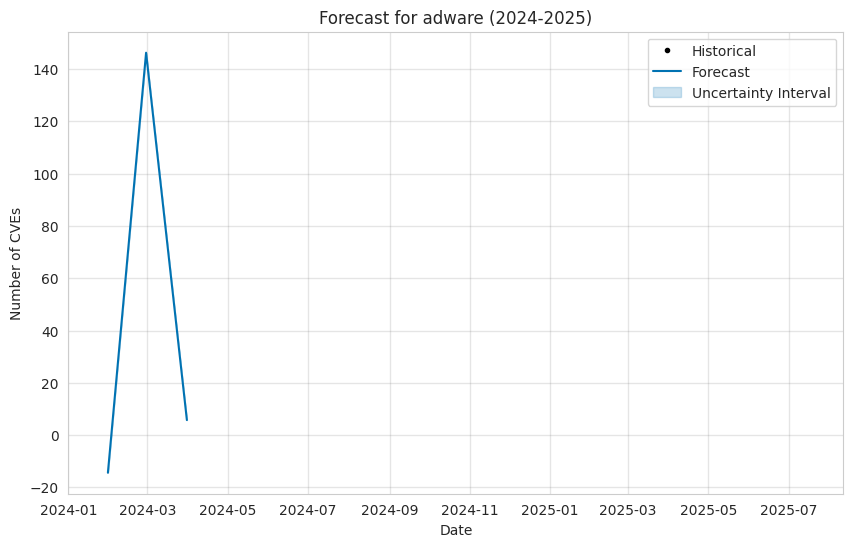

[2024-08-11 16:42:55.267] INFO [134610428276736] - n_changepoints greater than number of observations. Using 8.
[2024-08-11 16:42:55.272] DEBUG [134610428276736] - input tempfile: /tmp/tmpcuqfelo_/zdv2yi45.json
[2024-08-11 16:42:55.276] DEBUG [134610428276736] - input tempfile: /tmp/tmpcuqfelo_/ywkdgavp.json
[2024-08-11 16:42:55.278] DEBUG [134610428276736] - idx 0
[2024-08-11 16:42:55.279] DEBUG [134610428276736] - running CmdStan, num_threads: None
[2024-08-11 16:42:55.280] DEBUG [134610428276736] - CmdStan args: ['/home/ggimeno/dev/git/github/others/ai-osint-malware-analysis/.venv/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97493', 'data', 'file=/tmp/tmpcuqfelo_/zdv2yi45.json', 'init=/tmp/tmpcuqfelo_/ywkdgavp.json', 'output', 'file=/tmp/tmpcuqfelo_/prophet_model4t748fix/prophet_model-20240811164255.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:42:55 - cmdstanpy - INFO - Chain [1] start processing
[2024-08-11 16:42:55.281] INFO 

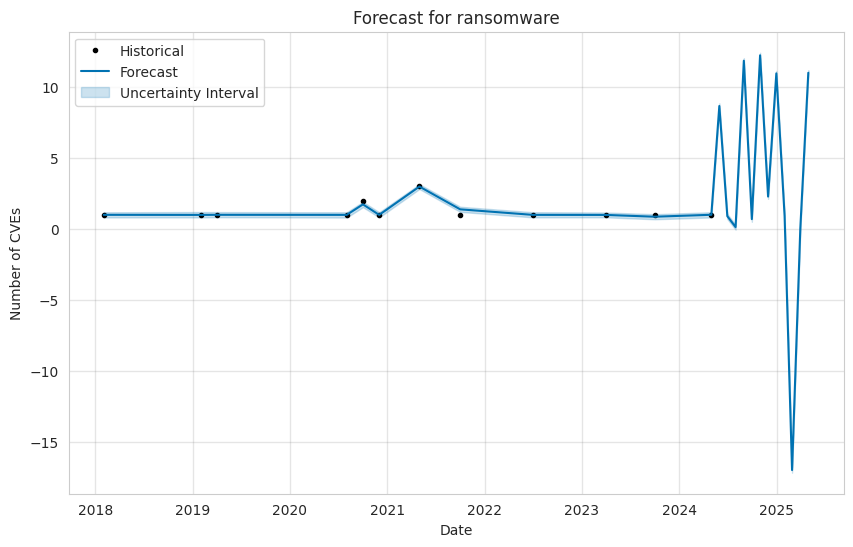

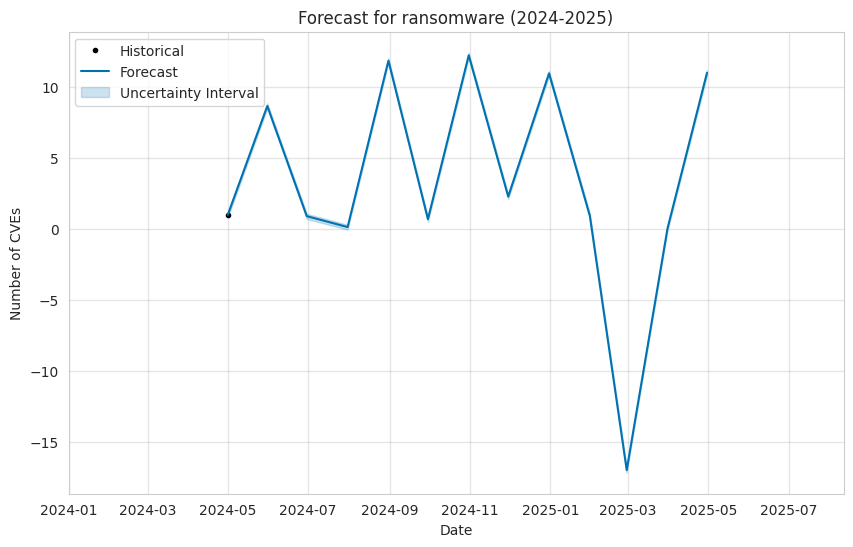

In [13]:
import os
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from dateutil.relativedelta import relativedelta

from config.logger import logger

# Create a list to store models and future dataframes
models = {}
forecast_dfs = {}

# Iterate over each malware type
for malware in grouped_df["malware_type_final"].unique():
    # Prepare the data for Prophet
    df_malware = grouped_df[grouped_df["malware_type_final"] == malware]

    if (
        df_malware.shape[0] < 2
        or df_malware["count"].isna().sum() >= df_malware.shape[0] - 1
    ):
        logger.warning(f"Not enough data for {malware}. Skipping this malware type.")
    else:

        df_prophet = df_malware.rename(columns={"date_published": "ds", "count": "y"})[
            ["ds", "y"]
        ]

        # Initialize and fit the model
        model = Prophet(
            yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False
        )
        model.fit(df_prophet)

        # Store the model
        models[malware] = model

        # Create a future dataframe for forecasting
        future = model.make_future_dataframe(
            periods=12, freq="M"
        )  # Forecast for 12 months into the future

        # Make predictions
        forecast = model.predict(future)
        forecast_dfs[malware] = forecast

        logger.info(f"Forecast for {malware} saved")

        # Plot forecast
        fig, ax = plt.subplots(figsize=(10, 6))
        model.plot(forecast, ax=ax)
        ax.set_title(f"Forecast for {malware}")
        ax.set_xlabel("Date")
        ax.set_ylabel("Number of CVEs")

        # Add legend
        ax.legend(["Historical", "Forecast", "Uncertainty Interval"])

        plt.show()

        # Filter the forecast to include only this year and next year
        current_year = datetime.now().year
        next_year = current_year + 1
        forecast_filtered = forecast[
            (forecast['ds'].dt.year >= current_year) & (forecast['ds'].dt.year <= next_year)
        ]

        # Plot forecast
        fig, ax = plt.subplots(figsize=(10, 6))
        model.plot(forecast_filtered, ax=ax)

        # Set x-axis limits to current year and next year
        ax.set_xlim([datetime(current_year, 1, 1), (datetime.now() + relativedelta(years=1))])

        ax.set_title(f"Forecast for {malware} ({current_year}-{next_year})")
        ax.set_xlabel("Date")
        ax.set_ylabel("Number of CVEs")

        # Add legend
        ax.legend(["Historical", "Forecast", "Uncertainty Interval"])

        plt.show()


In [9]:
# Evaluate each model
for malware, forecast in forecast_dfs.items():
    # Filter the forecast to only include the actual dates
    actual = grouped_df[grouped_df["malware_type_final"] == malware]
    forecast_filtered = forecast.loc[forecast["ds"].isin(actual["date_published"])]

    # Calculate metrics
    mae = mean_absolute_error(actual["count"], forecast_filtered["yhat"])
    mse = mean_squared_error(actual["count"], forecast_filtered["yhat"])
    rmse = mse**0.5

    logger.info(f"{malware} - MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")

### Forecasting 2 years from now
And now a forecasting of 2 years:

[2024-08-11 16:38:00.460] DEBUG [134610428276736] - input tempfile: /tmp/tmpcuqfelo_/sa6vjk0x.json
[2024-08-11 16:38:00.501] DEBUG [134610428276736] - input tempfile: /tmp/tmpcuqfelo_/vld3t5ak.json
[2024-08-11 16:38:00.504] DEBUG [134610428276736] - idx 0
[2024-08-11 16:38:00.506] DEBUG [134610428276736] - running CmdStan, num_threads: None
[2024-08-11 16:38:00.507] DEBUG [134610428276736] - CmdStan args: ['/home/ggimeno/dev/git/github/others/ai-osint-malware-analysis/.venv/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46251', 'data', 'file=/tmp/tmpcuqfelo_/sa6vjk0x.json', 'init=/tmp/tmpcuqfelo_/vld3t5ak.json', 'output', 'file=/tmp/tmpcuqfelo_/prophet_model4x8bxo2l/prophet_model-20240811163800.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:38:00 - cmdstanpy - INFO - Chain [1] start processing
[2024-08-11 16:38:00.508] INFO [134610428276736] - Chain [1] start processing
16:38:00 - cmdstanpy - INFO - Chain [1] done processing
[2024-08-1

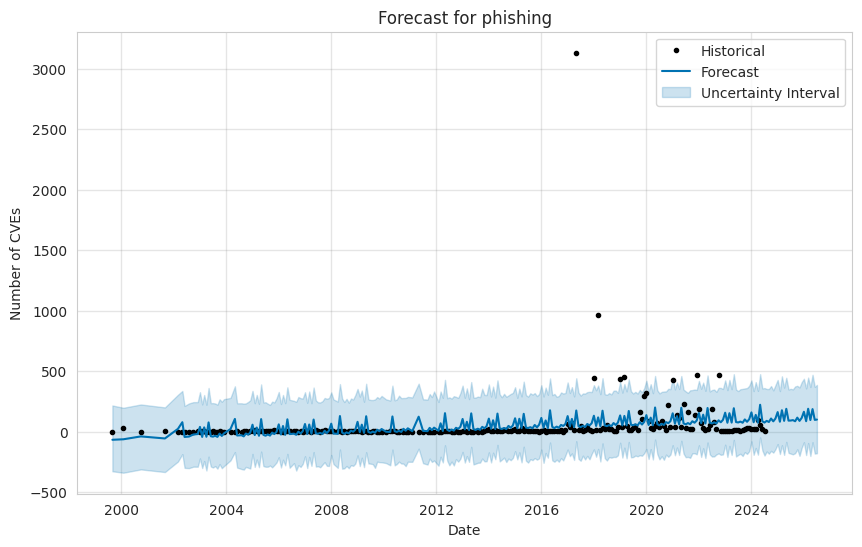

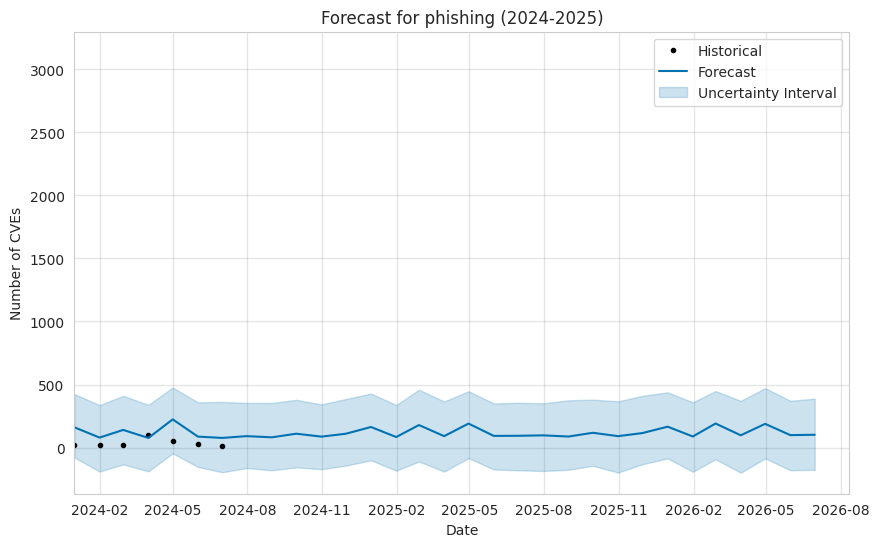

[2024-08-11 16:38:02.705] DEBUG [134610428276736] - input tempfile: /tmp/tmpcuqfelo_/cilstibf.json
[2024-08-11 16:38:02.735] DEBUG [134610428276736] - input tempfile: /tmp/tmpcuqfelo_/zkibqxfd.json
[2024-08-11 16:38:02.738] DEBUG [134610428276736] - idx 0
[2024-08-11 16:38:02.740] DEBUG [134610428276736] - running CmdStan, num_threads: None
[2024-08-11 16:38:02.742] DEBUG [134610428276736] - CmdStan args: ['/home/ggimeno/dev/git/github/others/ai-osint-malware-analysis/.venv/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9131', 'data', 'file=/tmp/tmpcuqfelo_/cilstibf.json', 'init=/tmp/tmpcuqfelo_/zkibqxfd.json', 'output', 'file=/tmp/tmpcuqfelo_/prophet_model__cynawp/prophet_model-20240811163802.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:38:02 - cmdstanpy - INFO - Chain [1] start processing
[2024-08-11 16:38:02.744] INFO [134610428276736] - Chain [1] start processing
16:38:02 - cmdstanpy - INFO - Chain [1] done processing
[2024-08-11

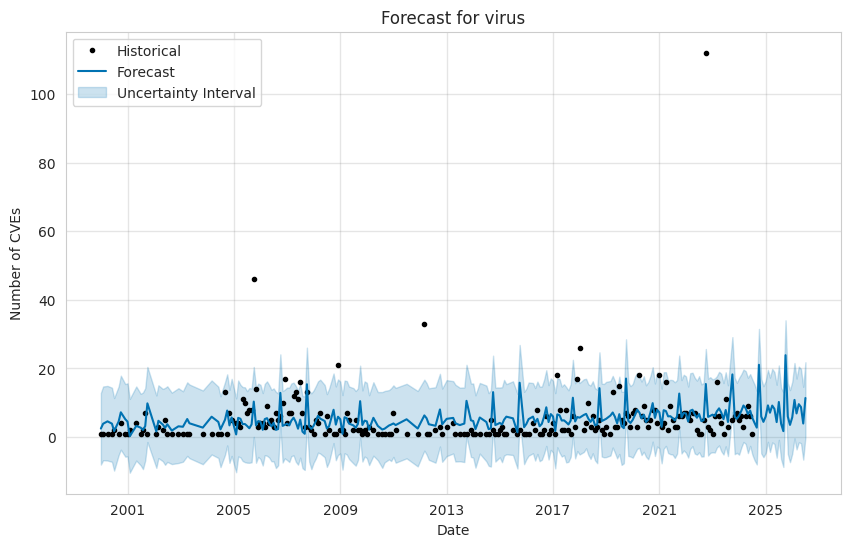

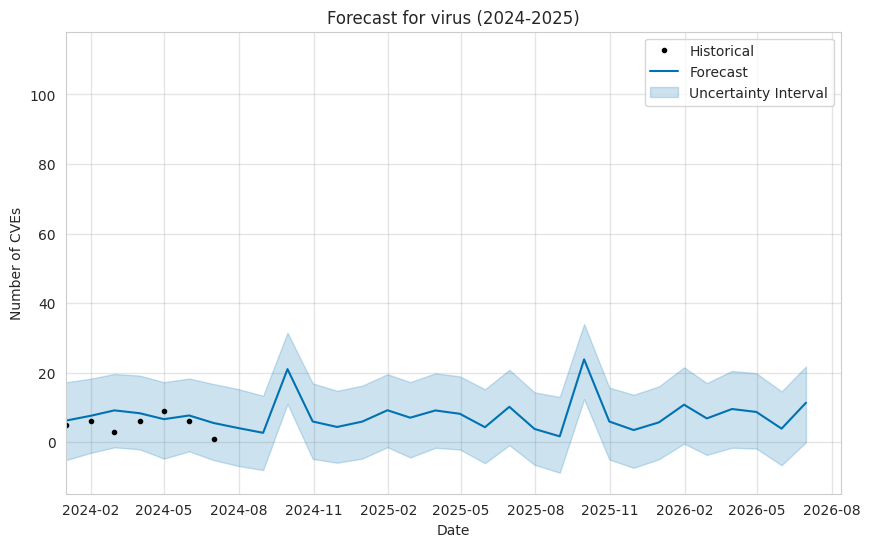

[2024-08-11 16:38:04.513] DEBUG [134610428276736] - input tempfile: /tmp/tmpcuqfelo_/rhs6stov.json
[2024-08-11 16:38:04.532] DEBUG [134610428276736] - input tempfile: /tmp/tmpcuqfelo_/lxmhd1_w.json
[2024-08-11 16:38:04.535] DEBUG [134610428276736] - idx 0
[2024-08-11 16:38:04.536] DEBUG [134610428276736] - running CmdStan, num_threads: None
[2024-08-11 16:38:04.538] DEBUG [134610428276736] - CmdStan args: ['/home/ggimeno/dev/git/github/others/ai-osint-malware-analysis/.venv/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85644', 'data', 'file=/tmp/tmpcuqfelo_/rhs6stov.json', 'init=/tmp/tmpcuqfelo_/lxmhd1_w.json', 'output', 'file=/tmp/tmpcuqfelo_/prophet_modeltoa1erwb/prophet_model-20240811163804.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:38:04 - cmdstanpy - INFO - Chain [1] start processing
[2024-08-11 16:38:04.540] INFO [134610428276736] - Chain [1] start processing
16:38:04 - cmdstanpy - INFO - Chain [1] done processing
[2024-08-1

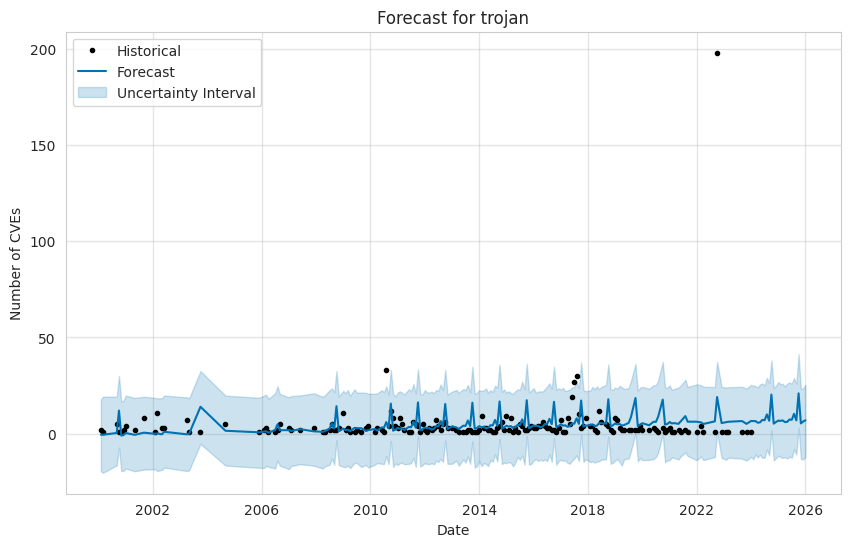

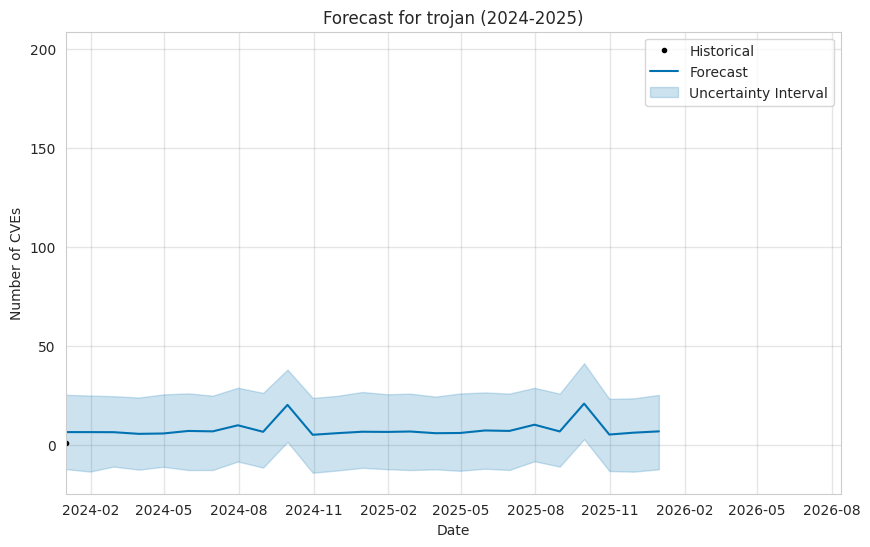

[2024-08-11 16:38:06.316] INFO [134610428276736] - n_changepoints greater than number of observations. Using 21.
[2024-08-11 16:38:06.322] DEBUG [134610428276736] - input tempfile: /tmp/tmpcuqfelo_/_f94_2xb.json
[2024-08-11 16:38:06.328] DEBUG [134610428276736] - input tempfile: /tmp/tmpcuqfelo_/up8fnd3c.json
[2024-08-11 16:38:06.331] DEBUG [134610428276736] - idx 0
[2024-08-11 16:38:06.333] DEBUG [134610428276736] - running CmdStan, num_threads: None
[2024-08-11 16:38:06.334] DEBUG [134610428276736] - CmdStan args: ['/home/ggimeno/dev/git/github/others/ai-osint-malware-analysis/.venv/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84805', 'data', 'file=/tmp/tmpcuqfelo_/_f94_2xb.json', 'init=/tmp/tmpcuqfelo_/up8fnd3c.json', 'output', 'file=/tmp/tmpcuqfelo_/prophet_modelxw74jnke/prophet_model-20240811163806.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:38:06 - cmdstanpy - INFO - Chain [1] start processing
[2024-08-11 16:38:06.335] INFO

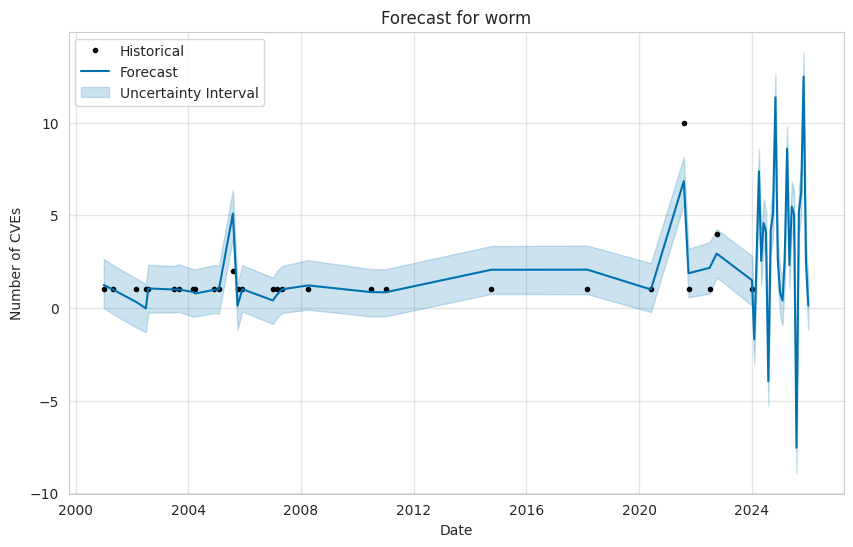

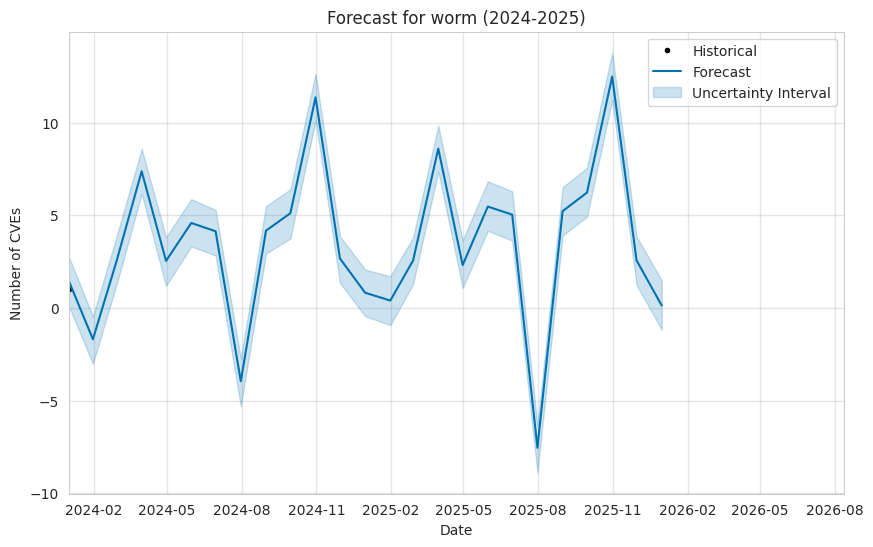

[2024-08-11 16:38:08.366] DEBUG [134610428276736] - input tempfile: /tmp/tmpcuqfelo_/xqbpd_ah.json
[2024-08-11 16:38:08.393] DEBUG [134610428276736] - input tempfile: /tmp/tmpcuqfelo_/28c611we.json
[2024-08-11 16:38:08.396] DEBUG [134610428276736] - idx 0
[2024-08-11 16:38:08.397] DEBUG [134610428276736] - running CmdStan, num_threads: None
[2024-08-11 16:38:08.399] DEBUG [134610428276736] - CmdStan args: ['/home/ggimeno/dev/git/github/others/ai-osint-malware-analysis/.venv/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80371', 'data', 'file=/tmp/tmpcuqfelo_/xqbpd_ah.json', 'init=/tmp/tmpcuqfelo_/28c611we.json', 'output', 'file=/tmp/tmpcuqfelo_/prophet_model84a185ir/prophet_model-20240811163808.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:38:08 - cmdstanpy - INFO - Chain [1] start processing
[2024-08-11 16:38:08.400] INFO [134610428276736] - Chain [1] start processing
16:38:08 - cmdstanpy - INFO - Chain [1] done processing
[2024-08-1

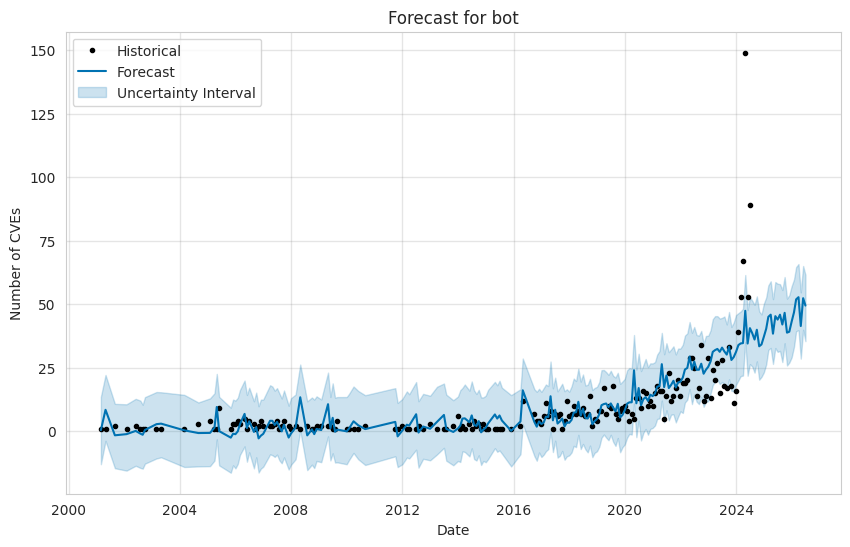

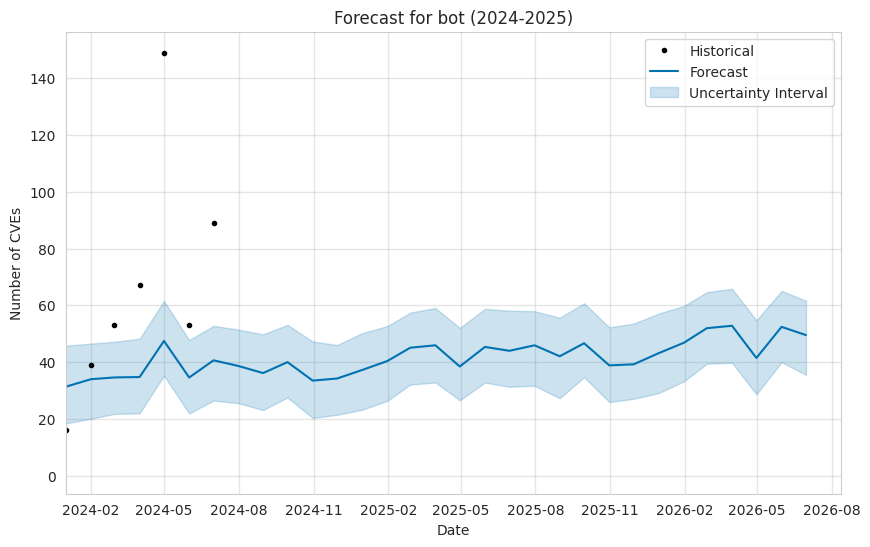

[2024-08-11 16:38:10.620] DEBUG [134610428276736] - input tempfile: /tmp/tmpcuqfelo_/dpabchkr.json
[2024-08-11 16:38:10.652] DEBUG [134610428276736] - input tempfile: /tmp/tmpcuqfelo_/0hggshzf.json
[2024-08-11 16:38:10.655] DEBUG [134610428276736] - idx 0
[2024-08-11 16:38:10.660] DEBUG [134610428276736] - running CmdStan, num_threads: None
[2024-08-11 16:38:10.662] DEBUG [134610428276736] - CmdStan args: ['/home/ggimeno/dev/git/github/others/ai-osint-malware-analysis/.venv/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43425', 'data', 'file=/tmp/tmpcuqfelo_/dpabchkr.json', 'init=/tmp/tmpcuqfelo_/0hggshzf.json', 'output', 'file=/tmp/tmpcuqfelo_/prophet_modelc032ysqy/prophet_model-20240811163810.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:38:10 - cmdstanpy - INFO - Chain [1] start processing
[2024-08-11 16:38:10.663] INFO [134610428276736] - Chain [1] start processing
16:38:10 - cmdstanpy - INFO - Chain [1] done processing
[2024-08-1

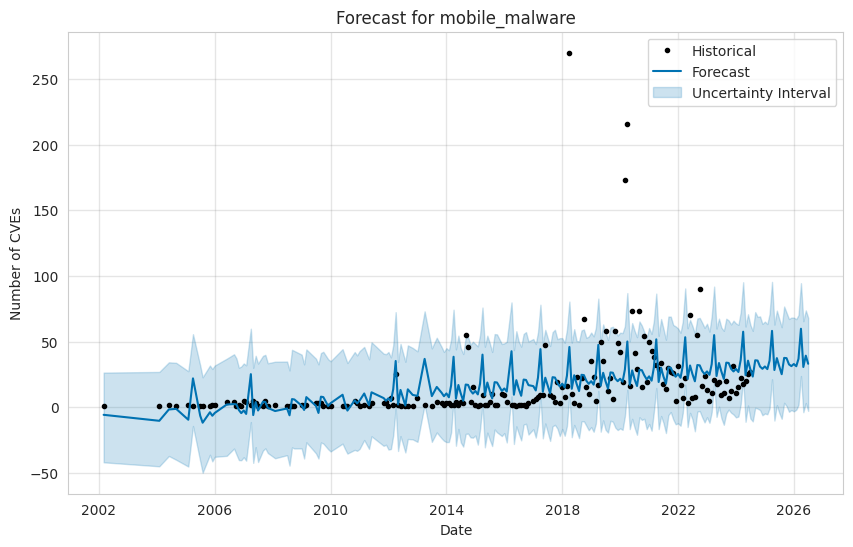

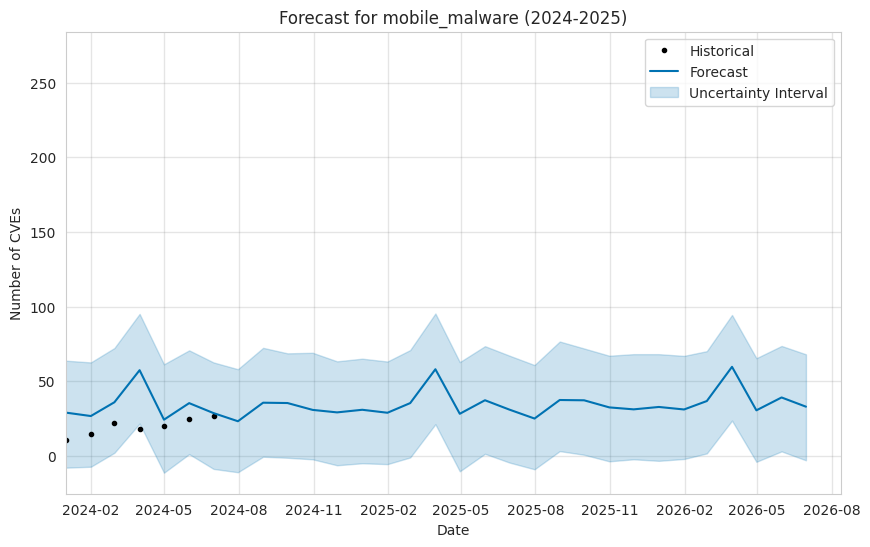

[2024-08-11 16:38:12.608] INFO [134610428276736] - n_changepoints greater than number of observations. Using 12.
[2024-08-11 16:38:12.614] DEBUG [134610428276736] - input tempfile: /tmp/tmpcuqfelo_/70x_h_9c.json
[2024-08-11 16:38:12.619] DEBUG [134610428276736] - input tempfile: /tmp/tmpcuqfelo_/l8diztym.json
[2024-08-11 16:38:12.622] DEBUG [134610428276736] - idx 0
[2024-08-11 16:38:12.624] DEBUG [134610428276736] - running CmdStan, num_threads: None
[2024-08-11 16:38:12.625] DEBUG [134610428276736] - CmdStan args: ['/home/ggimeno/dev/git/github/others/ai-osint-malware-analysis/.venv/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7994', 'data', 'file=/tmp/tmpcuqfelo_/70x_h_9c.json', 'init=/tmp/tmpcuqfelo_/l8diztym.json', 'output', 'file=/tmp/tmpcuqfelo_/prophet_modeltss7ke2k/prophet_model-20240811163812.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:38:12 - cmdstanpy - INFO - Chain [1] start processing
[2024-08-11 16:38:12.627] INFO 

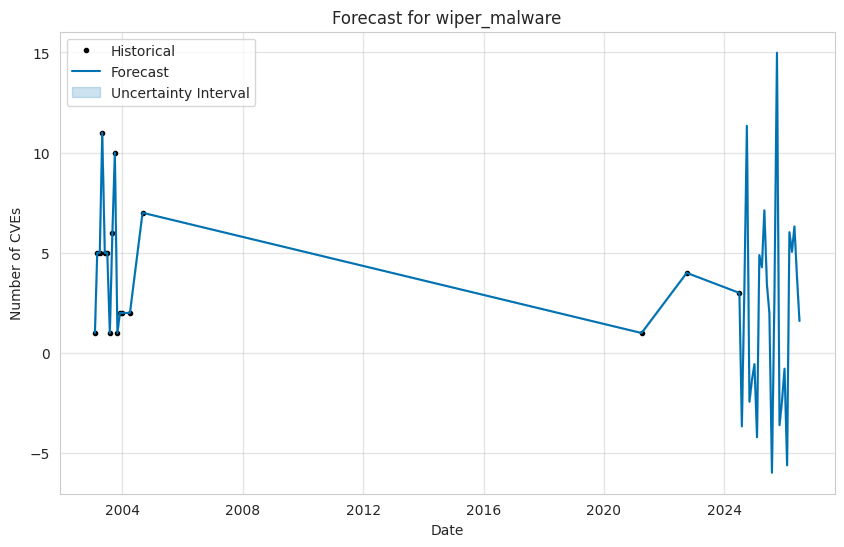

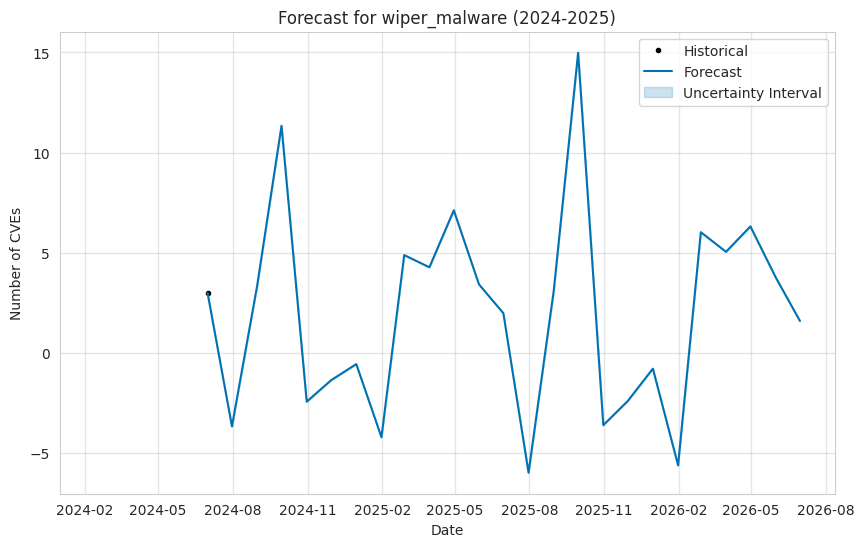

[2024-08-11 16:38:15.464] INFO [134610428276736] - n_changepoints greater than number of observations. Using 5.
/home/ggimeno/dev/git/github/others/ai-osint-malware-analysis/.venv/lib/python3.10/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
/home/ggimeno/dev/git/github/others/ai-osint-malware-analysis/.venv/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/ggimeno/dev/git/github/others/ai-osint-malware-analysis/.venv/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Serie

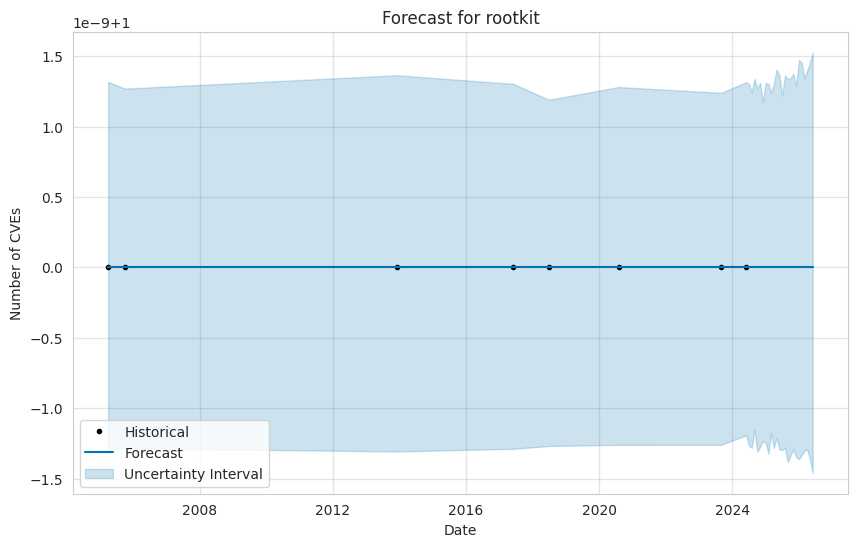

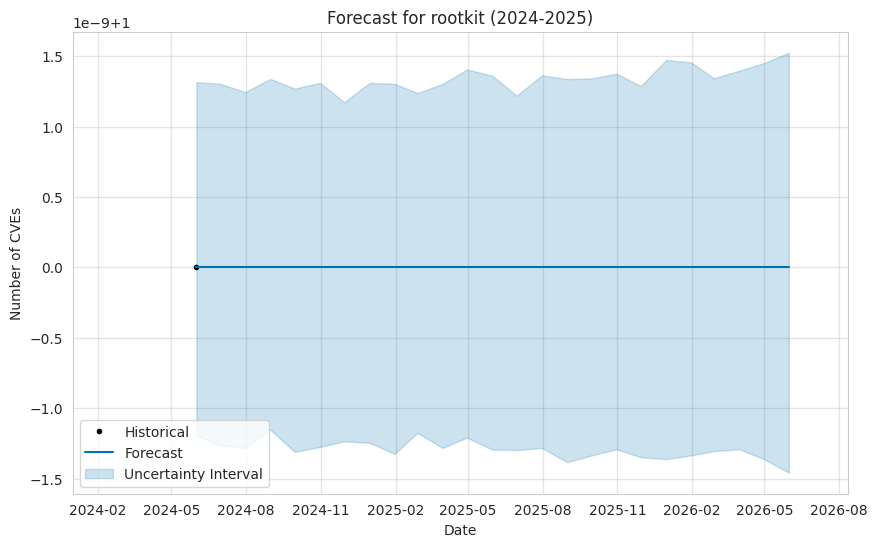

[2024-08-11 16:38:17.341] INFO [134610428276736] - n_changepoints greater than number of observations. Using 9.
[2024-08-11 16:38:17.348] DEBUG [134610428276736] - input tempfile: /tmp/tmpcuqfelo_/5v6c3gzk.json
[2024-08-11 16:38:17.355] DEBUG [134610428276736] - input tempfile: /tmp/tmpcuqfelo_/rxyoz6wg.json
[2024-08-11 16:38:17.359] DEBUG [134610428276736] - idx 0
[2024-08-11 16:38:17.360] DEBUG [134610428276736] - running CmdStan, num_threads: None
[2024-08-11 16:38:17.362] DEBUG [134610428276736] - CmdStan args: ['/home/ggimeno/dev/git/github/others/ai-osint-malware-analysis/.venv/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23728', 'data', 'file=/tmp/tmpcuqfelo_/5v6c3gzk.json', 'init=/tmp/tmpcuqfelo_/rxyoz6wg.json', 'output', 'file=/tmp/tmpcuqfelo_/prophet_modelnpr1s901/prophet_model-20240811163817.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:38:17 - cmdstanpy - INFO - Chain [1] start processing
[2024-08-11 16:38:17.363] INFO 

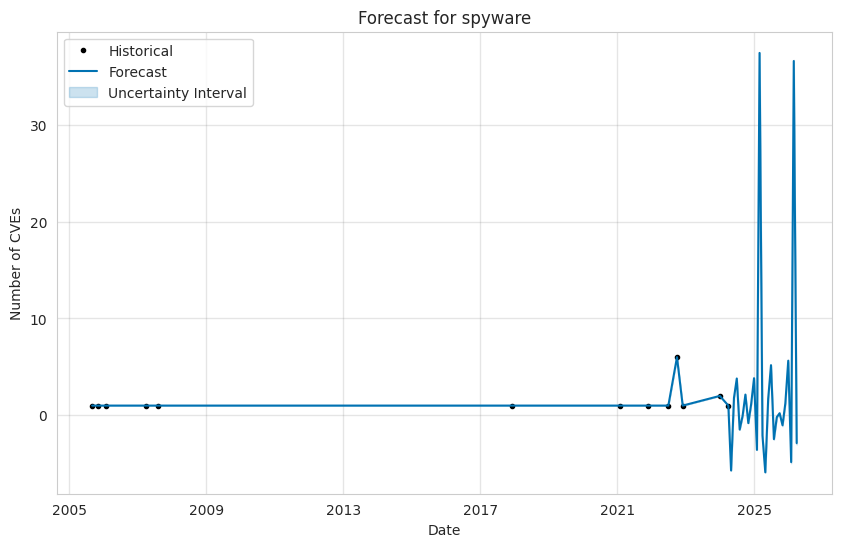

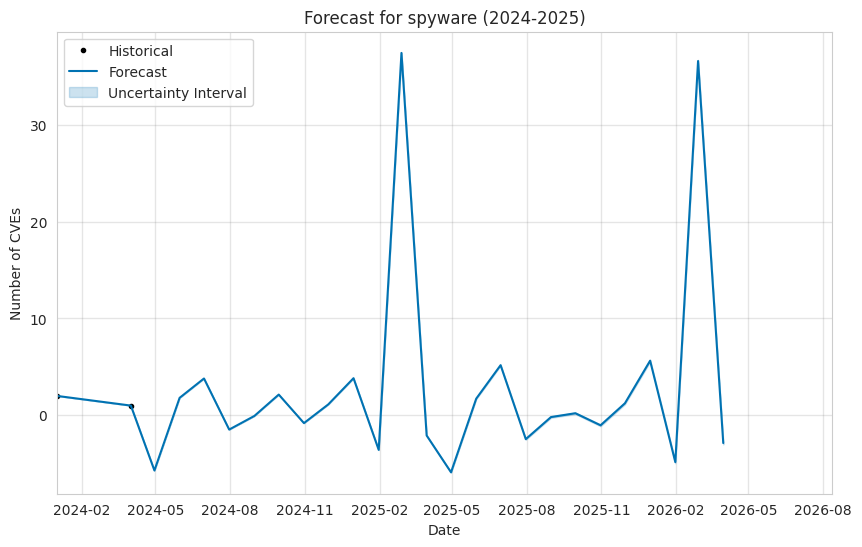

[2024-08-11 16:38:26.122] INFO [134610428276736] - n_changepoints greater than number of observations. Using 4.
[2024-08-11 16:38:26.129] DEBUG [134610428276736] - input tempfile: /tmp/tmpcuqfelo_/gxd7nacd.json
[2024-08-11 16:38:26.133] DEBUG [134610428276736] - input tempfile: /tmp/tmpcuqfelo_/tty_j97m.json
[2024-08-11 16:38:26.136] DEBUG [134610428276736] - idx 0
[2024-08-11 16:38:26.138] DEBUG [134610428276736] - running CmdStan, num_threads: None
[2024-08-11 16:38:26.140] DEBUG [134610428276736] - CmdStan args: ['/home/ggimeno/dev/git/github/others/ai-osint-malware-analysis/.venv/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25983', 'data', 'file=/tmp/tmpcuqfelo_/gxd7nacd.json', 'init=/tmp/tmpcuqfelo_/tty_j97m.json', 'output', 'file=/tmp/tmpcuqfelo_/prophet_model6yg3u1zc/prophet_model-20240811163826.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:38:26 - cmdstanpy - INFO - Chain [1] start processing
[2024-08-11 16:38:26.141] INFO 

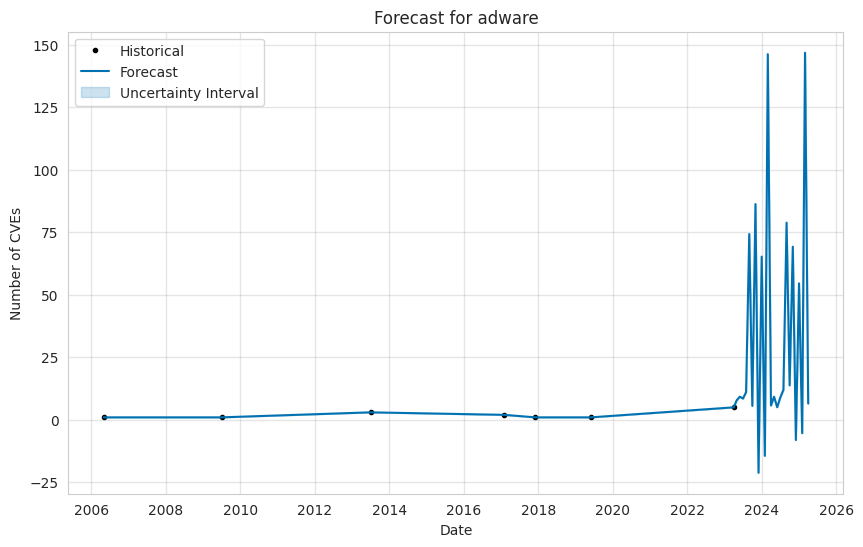

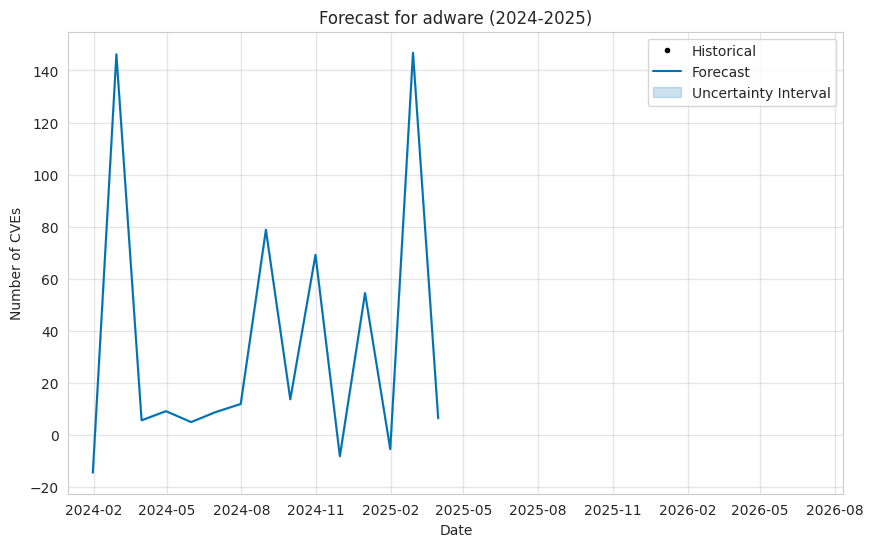

[2024-08-11 16:38:32.808] INFO [134610428276736] - n_changepoints greater than number of observations. Using 8.
[2024-08-11 16:38:32.815] DEBUG [134610428276736] - input tempfile: /tmp/tmpcuqfelo_/p0gfatwr.json
[2024-08-11 16:38:32.819] DEBUG [134610428276736] - input tempfile: /tmp/tmpcuqfelo_/3ousp4cu.json
[2024-08-11 16:38:32.822] DEBUG [134610428276736] - idx 0
[2024-08-11 16:38:32.823] DEBUG [134610428276736] - running CmdStan, num_threads: None
[2024-08-11 16:38:32.825] DEBUG [134610428276736] - CmdStan args: ['/home/ggimeno/dev/git/github/others/ai-osint-malware-analysis/.venv/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96711', 'data', 'file=/tmp/tmpcuqfelo_/p0gfatwr.json', 'init=/tmp/tmpcuqfelo_/3ousp4cu.json', 'output', 'file=/tmp/tmpcuqfelo_/prophet_modeln3lx3cms/prophet_model-20240811163832.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:38:32 - cmdstanpy - INFO - Chain [1] start processing
[2024-08-11 16:38:32.827] INFO 

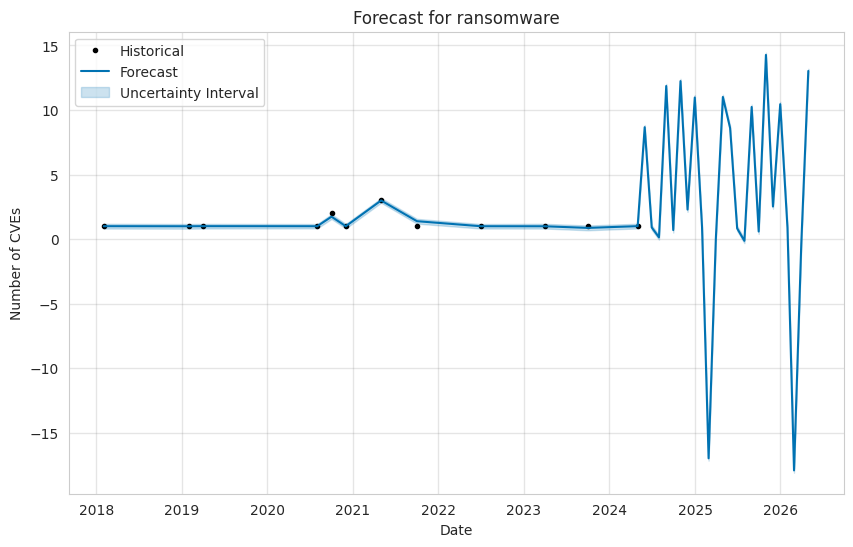

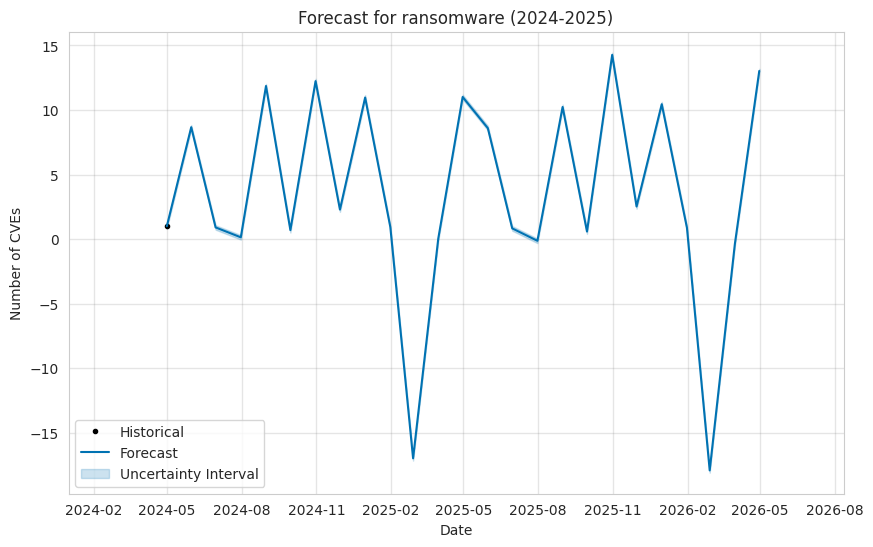

In [8]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from dateutil.relativedelta import relativedelta

from config.logger import logger

# Create a list to store models and future dataframes
models = {}
forecast_dfs = {}

# Iterate over each malware type
for malware in grouped_df["malware_type_final"].unique():
    # Prepare the data for Prophet
    df_malware = grouped_df[grouped_df["malware_type_final"] == malware]

    if (
        df_malware.shape[0] < 2
        or df_malware["count"].isna().sum() >= df_malware.shape[0] - 1
    ):
        logger.warning(f"Not enough data for {malware}. Skipping this malware type.")
    else:

        df_prophet = df_malware.rename(columns={"date_published": "ds", "count": "y"})[
            ["ds", "y"]
        ]

        # Initialize and fit the model
        model = Prophet(
            yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False
        )
        model.fit(df_prophet)

        # Store the model
        models[malware] = model

        # Create a future dataframe for forecasting
        future = model.make_future_dataframe(
            periods=24, freq="M"
        )  # Forecast for 12 months into the future

        # Make predictions
        forecast = model.predict(future)
        forecast_dfs[malware] = forecast

        logger.info(f"Forecast for {malware} saved")

        # Plot forecast
        fig, ax = plt.subplots(figsize=(10, 6))
        model.plot(forecast, ax=ax)
        ax.set_title(f"Forecast for {malware}")
        ax.set_xlabel("Date")
        ax.set_ylabel("Number of CVEs")

        # Add legend
        ax.legend(["Historical", "Forecast", "Uncertainty Interval"])

        plt.show()

        # Filter the forecast to include only this year and next year
        current_year = datetime.now().year
        final_year = current_year + 2
        forecast_filtered = forecast[
            (forecast['ds'].dt.year >= current_year) & (forecast['ds'].dt.year <= final_year)
        ]

        # Plot forecast
        fig, ax = plt.subplots(figsize=(10, 6))
        model.plot(forecast_filtered, ax=ax)

        # Set x-axis limits to current year and next year
        ax.set_xlim([datetime(current_year, 1, 1), (datetime.now() + relativedelta(years=2))])

        ax.set_title(f"Forecast for {malware} ({current_year}-{next_year})")
        ax.set_xlabel("Date")
        ax.set_ylabel("Number of CVEs")

        # Add legend
        ax.legend(["Historical", "Forecast", "Uncertainty Interval"])

        plt.show()

In [ ]:
# Evaluate each model
for malware, forecast in forecast_dfs.items():
    # Filter the forecast to only include the actual dates
    actual = grouped_df[grouped_df["malware_type_final"] == malware]
    forecast_filtered = forecast.loc[forecast["ds"].isin(actual["date_published"])]

    # Calculate metrics
    mae = mean_absolute_error(actual["count"], forecast_filtered["yhat"])
    mse = mean_squared_error(actual["count"], forecast_filtered["yhat"])
    rmse = mse**0.5

    logger.info(f"{malware} - MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")